In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
sns.set(style="whitegrid")

# Paths
DATA_DIR = Path("/Users/hwangsia/Desktop/open")
SAVE_DIR = Path("reports/figures")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Load data
train = pd.read_parquet(DATA_DIR / "train.parquet")


In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

SEED = 42
y_all = train["clicked"].astype(int)

# dev vs holdout (85% / 15%)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
dev_idx, hold_idx = next(sss1.split(train.index, y_all))
dev_df     = train.iloc[dev_idx].reset_index(drop=True)
holdout_df = train.iloc[hold_idx].reset_index(drop=True)

# dev --> train/valid (68/17/15)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
y_dev = dev_df["clicked"].astype(int)
tr_idx, va_idx = next(sss2.split(dev_df.index, y_dev))
train_df = dev_df.iloc[tr_idx].reset_index(drop=True)
valid_df = dev_df.iloc[va_idx].reset_index(drop=True)

print(
    f"Train:   {train_df.shape}  (pos={train_df['clicked'].mean():.4f})\n"
    f"Valid:   {valid_df.shape}  (pos={valid_df['clicked'].mean():.4f})\n"
    f"Holdout: {holdout_df.shape} (pos={holdout_df['clicked'].mean():.4f})"
)


Train:   (7278841, 119)  (pos=0.0191)
Valid:   (1819711, 119)  (pos=0.0191)
Holdout: (1605627, 119) (pos=0.0191)


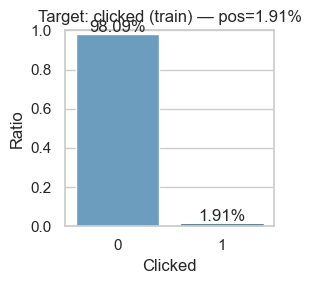

In [3]:
# Target Variable Analysis: 'clicked' (class imbalance check)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Compute clicked class distribution
clicked_counts = train_df["clicked"].value_counts()
clicked_ratio = train_df["clicked"].value_counts(normalize=True)

# Create summary DataFrame
df_clicked_summary = pd.DataFrame({
    "count": clicked_counts,
    "ratio": clicked_ratio
})

# Bar plot: clicked distribution
plt.figure(figsize=(3, 3))
sns.barplot(
    x=df_clicked_summary.index,
    y=df_clicked_summary["ratio"],
    hue=df_clicked_summary.index,
    legend=False,
    palette="Blues_d"
)
plt.title(f"Target: clicked (train) — pos={train_df['clicked'].mean():.2%}")
plt.ylabel("Ratio")
plt.xlabel("Clicked")
plt.ylim(0, 1)

# Add ratio text on bars
for i, v in enumerate(df_clicked_summary["ratio"]):
    plt.text(i, v + 0.01, f"{v:.2%}", ha="center")

plt.tight_layout()
plt.savefig(SAVE_DIR / "target_clicked_distribution.png")
plt.show()

### Target Variable Analysis — clicked
- Positive rate: 1.91% → Severe class imbalance confirmed.
- Due to extreme imbalance + 10M+ rows, initial model training proceeded without resampling to avoid overfitting minority class.
- Class imbalance handled via scale_pos_weight in tree-based models.

In [4]:
# missing value summary
na_counts = train_df.isna().sum()
na_ratio = (train_df.isna().mean() * 100).round(2).astype(str) + '%'
na_df = pd.concat([na_counts, na_ratio], axis=1)
na_df.columns = ["missing_count", "missing_ratio"]
na_df = na_df[na_df["missing_count"] > 0]
na_df = na_df.sort_values(by="missing_count", ascending=False)
print(na_df.head(4))

           missing_count missing_ratio
feat_e_3          738215        10.14%
feat_a_8           12575         0.17%
feat_a_15          12575         0.17%
feat_a_17          12575         0.17%


### Missing Value Check

Most features show negligible missingness (below 0.2%), except `feat_e_3` with ~10% missing rate.  
→ Only `feat_e_3` may require special handling.  
However, since LGBM can robustly handle missing values, no imputation is applied at this stage.

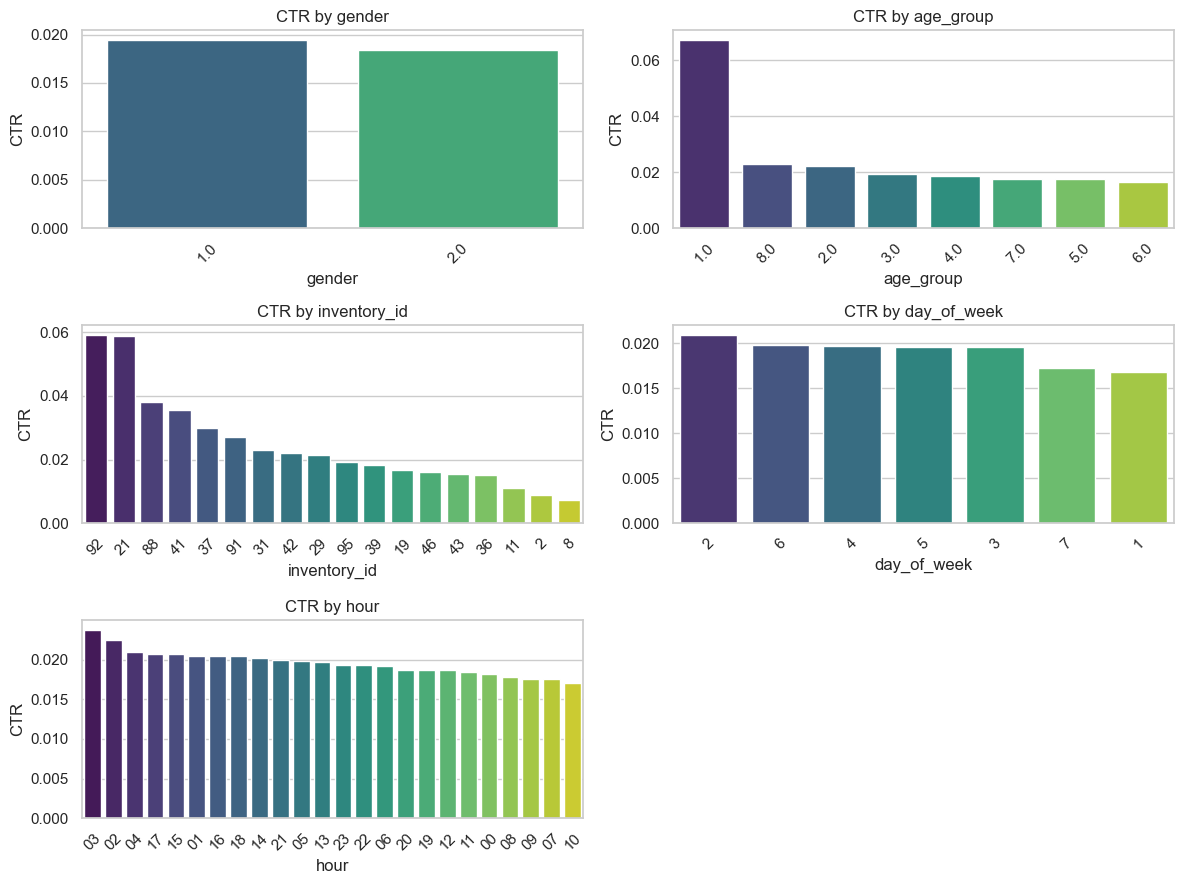

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ["gender", "age_group", "inventory_id", "day_of_week", "hour"]
n = len(cat_cols)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))

for idx, col in enumerate(cat_cols):
    row, col_idx = divmod(idx, ncols)
    ax = axes[row][col_idx] if nrows > 1 else axes[col_idx]
    
    ctr = train_df.groupby(col)["clicked"].mean().sort_values(ascending=False)
    
    sns.barplot(
        x=ctr.index.astype(str),
        y=ctr.values,
        ax=ax,
        palette="viridis"
    )
    
    ax.set_title(f"CTR by {col}")
    ax.set_ylabel("CTR")
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)

# Hide any empty subplot
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

CTR by categorical features
- Noticeable CTR gaps in age_group and inventory_id → key segmentation signals
- Day of week and hour show mild but consistent trends

In [6]:
# Convert selected columns to category dtype
def convert_to_category(df, cols):
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = out[c].astype("Float64").round().astype("Int64").astype("category")
    return out

cat_cols = ["gender", "age_group", "inventory_id", "day_of_week", "hour"]

l_feat_discrete = [
    'l_feat_1','l_feat_2','l_feat_3','l_feat_4','l_feat_8','l_feat_13',
    'l_feat_16','l_feat_18','l_feat_19','l_feat_20','l_feat_21',
    'l_feat_22','l_feat_23','l_feat_24','l_feat_26','l_feat_27'
]

train_df   = convert_to_category(train_df,   cat_cols + l_feat_discrete)
valid_df   = convert_to_category(valid_df,   cat_cols + l_feat_discrete)
holdout_df = convert_to_category(holdout_df, cat_cols + l_feat_discrete)

    

In [7]:
# Identify l_feat_* variables treated as continuous
l_feat_continuous = [
    col for col in train_df.columns
    if col.startswith("l_feat_") and col not in l_feat_discrete
]
print("Continuous l_feat_* features:", l_feat_continuous)

Continuous l_feat_* features: ['l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_9', 'l_feat_10', 'l_feat_11', 'l_feat_12', 'l_feat_14', 'l_feat_15', 'l_feat_17', 'l_feat_25']


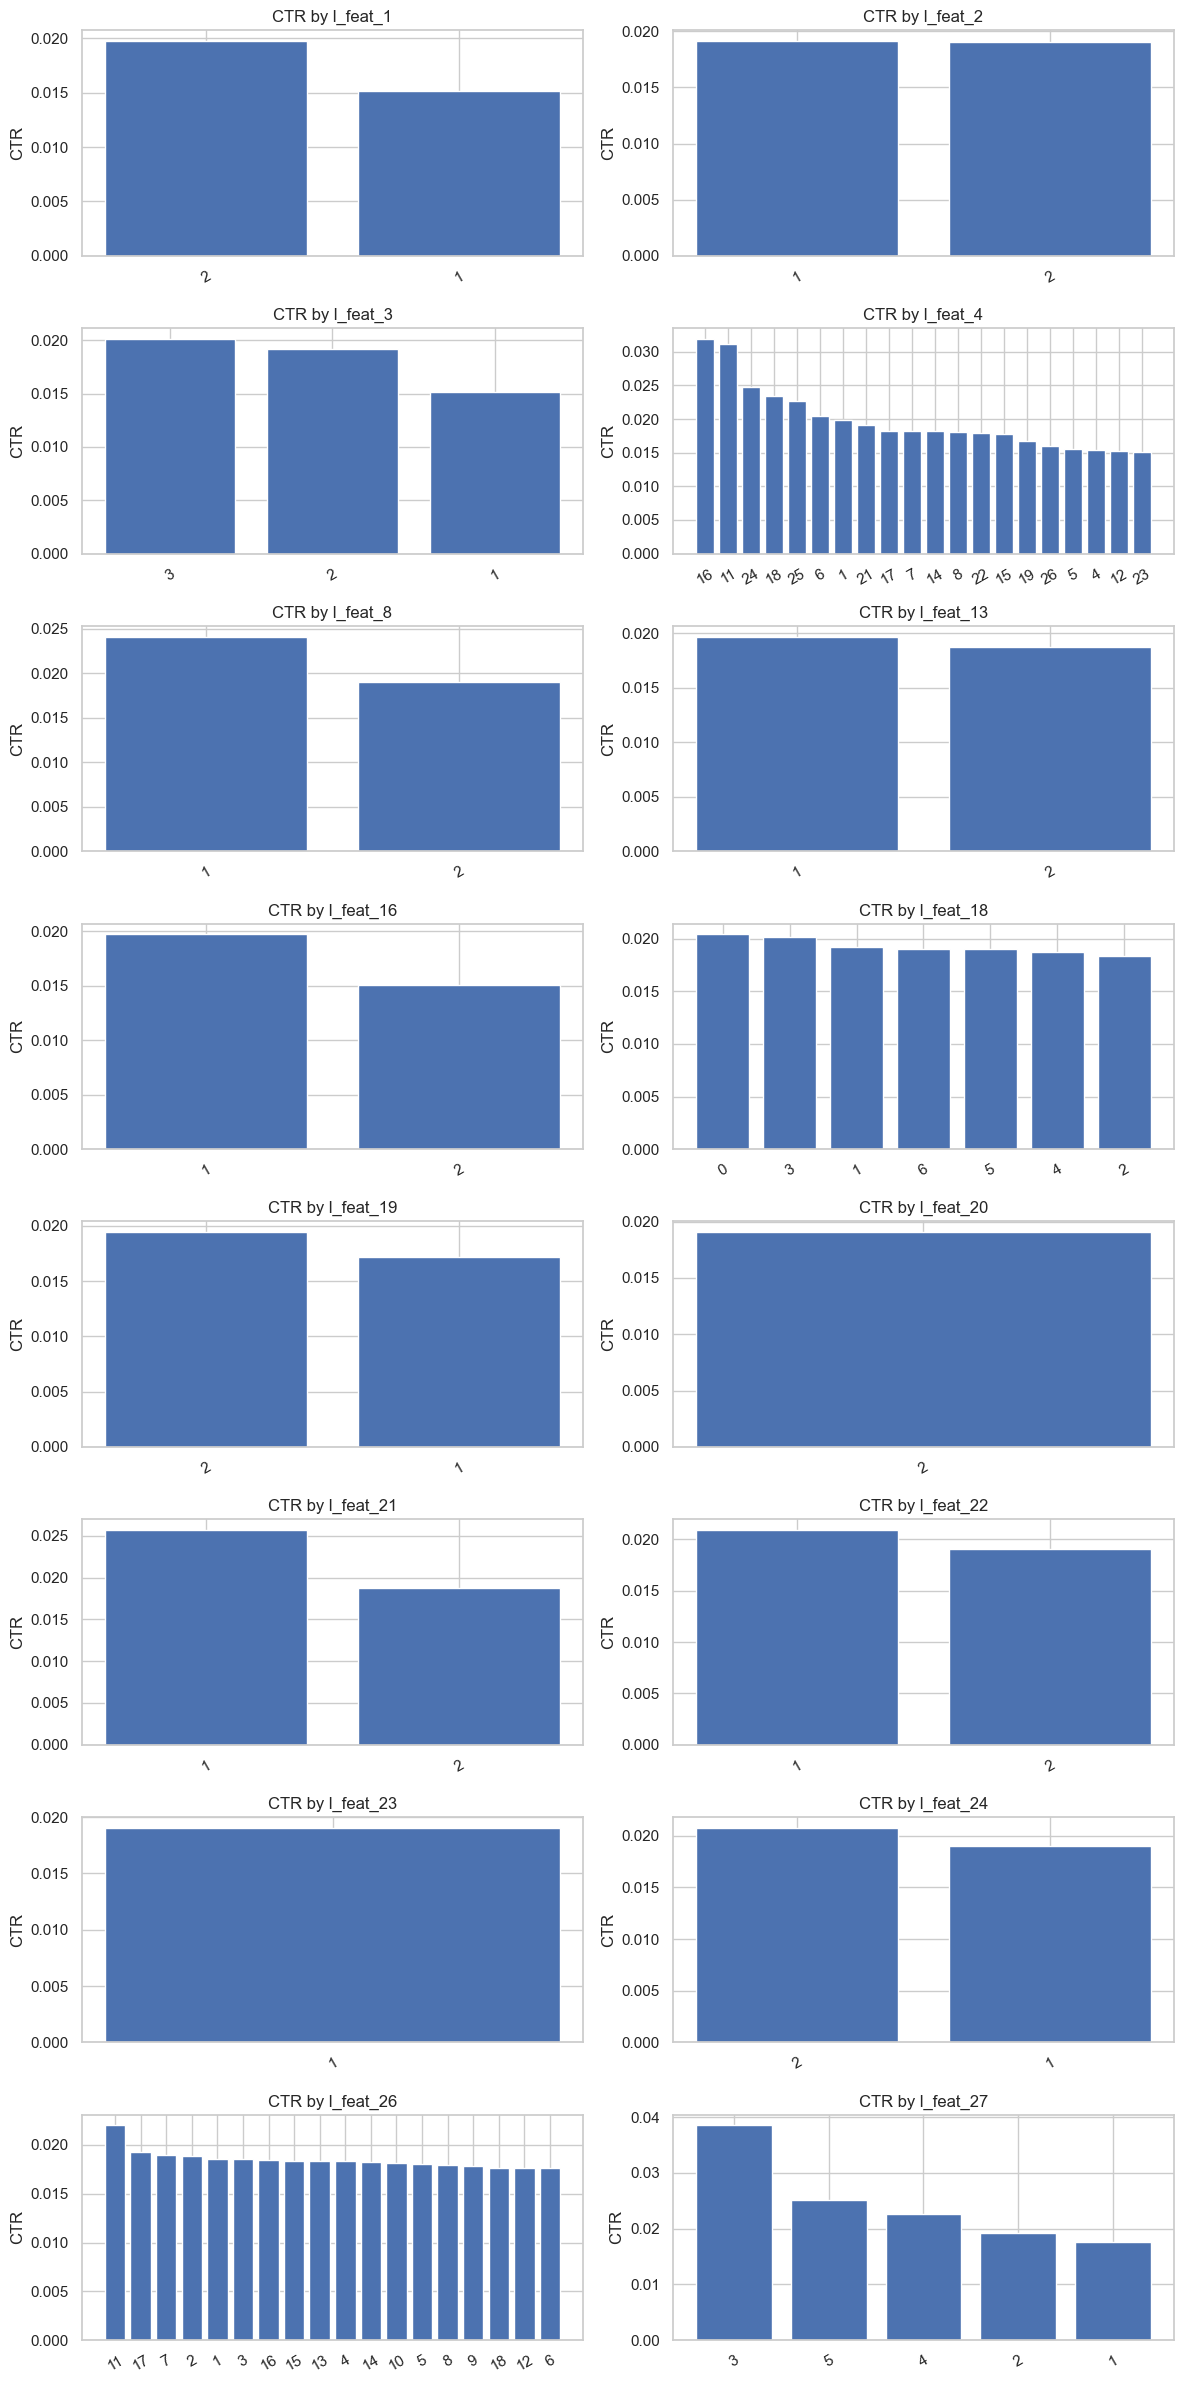

In [8]:
# CTR by discrete l_feat_* (Top-20 per variable, 2-column grid)
import matplotlib.pyplot as plt

TOP_K = 20
n_cols = 2
n_rows = (len(l_feat_discrete) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

ctr_maps = {}
for i, col in enumerate(l_feat_discrete):
    ctr = train_df.groupby(col)["clicked"].mean()
    ctr_maps[col] = ctr  
    top_ctr = ctr.sort_values(ascending=False).head(TOP_K)

    axes[i].bar(top_ctr.index.astype(str), top_ctr.values)
    axes[i].set_title(f"CTR by {col}")
    axes[i].set_ylabel("CTR")
    axes[i].tick_params(axis="x", rotation=30)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [9]:
# Remove columns with minimal predictive value
# - l_feat_2, l_feat_13: Almost no CTR distribution difference between groups
# - l_feat_20, l_feat_23: Single unique value only (no variance)
columns_to_drop = ['l_feat_2', 'l_feat_13', 'l_feat_20', 'l_feat_23']

for df in (train_df, valid_df, holdout_df):
    df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


In [10]:
# l_feat_continuous - Missing value ratio
na_ratio_cont = train_df[l_feat_continuous].isnull().mean().sort_values(ascending=False)
print(na_ratio_cont)

# l_feat_continuous - Summary statistics
train_df[l_feat_continuous].describe().T

l_feat_5     0.0
l_feat_6     0.0
l_feat_7     0.0
l_feat_9     0.0
l_feat_10    0.0
l_feat_11    0.0
l_feat_12    0.0
l_feat_14    0.0
l_feat_15    0.0
l_feat_17    0.0
l_feat_25    0.0
dtype: float64


,count,mean,std,min,25%,50%,75%,max
l_feat_5,7278841.0,393.892487,290.037201,1.0,105.0,376.0,652.0,1079.0
l_feat_6,7278841.0,314.865112,231.357285,1.0,109.0,278.0,471.0,903.0
l_feat_7,7278841.0,147.924988,71.936584,1.0,94.0,146.0,212.0,313.0
l_feat_9,7278841.0,212.839951,125.120094,1.0,101.0,225.0,309.0,476.0
l_feat_10,7278841.0,123.951164,62.097912,1.0,83.0,125.0,179.0,262.0
l_feat_11,7278841.0,623.529663,392.230988,1.0,288.0,595.0,949.0,1527.0
l_feat_12,7278841.0,2348.734619,1541.058838,1.0,878.0,2247.0,3916.0,5061.0
l_feat_14,7278841.0,1906.725952,978.708618,1.0,1055.0,2114.0,2924.0,3245.0
l_feat_15,7278841.0,1298.437378,787.345032,1.0,613.0,1190.0,2304.0,2590.0
l_feat_17,7278841.0,212.839951,125.120094,1.0,101.0,225.0,309.0,476.0


In [11]:
# Drop perfectly correlated or near-constant columns

corr_value = train_df[['l_feat_9', 'l_feat_17']].corr().iloc[0, 1]
print(f"Correlation between l_feat_9 and l_feat_17: {corr_value:.4f}")

# l_feat_9 and l_feat_17: perfectly correlated --> drop one
# l_feat_25: CTR distribution nearly identical to another variable → low predictive value

for df in (train_df, valid_df, holdout_df):
    df.drop(columns=['l_feat_17', 'l_feat_25'], errors='ignore', inplace=True)


Correlation between l_feat_9 and l_feat_17: 1.0000


In [12]:
# Convert continuous l_feat_* columns to integer (based on observed value distribution)
int_cols = ['l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_9', 'l_feat_10',
            'l_feat_11', 'l_feat_12', 'l_feat_14', 'l_feat_15']

for df in (train_df, valid_df, holdout_df):
    for c in int_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')

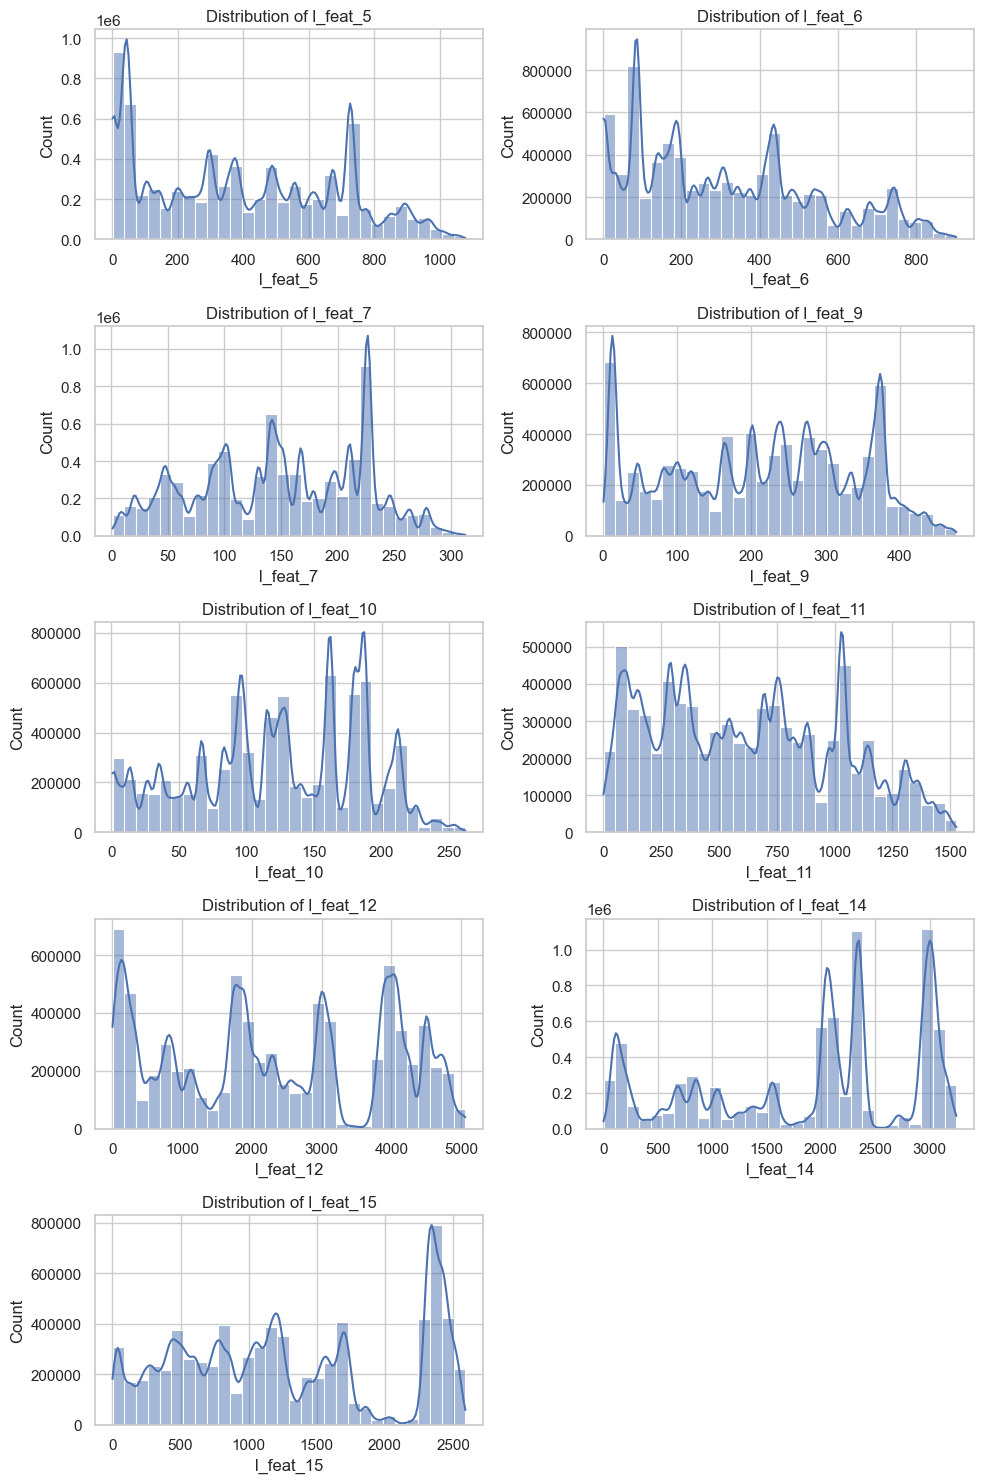

In [13]:
# Plot histograms for l_feat_* integer features (2 plots per row)
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 2
n_rows = (len(int_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(int_cols):
    sns.histplot(data=train_df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### l_feat_* — what I kept, dropped, and why

- **Type decision.** Treat as *categorical* when #unique ≤ **25**, otherwise keep as integer. This is a pragmatic cut-off to avoid high‑cardinality sparsity; scikit‑learn notes that OHE with many categories inflates dimensionality and suggests alternatives (e.g., target/ordinal encoders). XGBoost can use pandas category directly via enable_categorical, so OHE was not required.  [oai_citation:0‡scikit-learn.org](https://scikit-learn.org/stable/modules/preprocessing.html) [oai_citation:1‡xgboost.readthedocs.io](https://xgboost.readthedocs.io/en/release_1.7.0/python/python_api.htm)

- **Constant / near-constant / duplicate signals → drop.**  
  Dropped single‑level features (l_feat_20, l_feat_23) and a duplicate signal (l_feat_17 ≈ l_feat_9). Removing (near-)constant features is standard (VarianceThreshold). 

- **Low utility by outcome separation.**  
  l_feat_2, l_feat_13 showed almost identical CTR by bins to peer feature → removed (no predictive separation). *(dataset-specific decision)*

- **Distributions.**  
  Continuous l_feat_* are multi‑modal; kept as **int** after inspecting value quantization (summary & histograms).

In [14]:
# feat_e_* features — summary, histograms, correlations
# 1. feat_e_* feature summary
feat_e_cols = sorted([c for c in train_df.columns if c.startswith('feat_e_')])
train_df[feat_e_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_e_1,7267221.0,61.123955,9.932709,0.361111,63.555557,65.000000,65.000000,65.000000
feat_e_10,7267221.0,-303.916168,209.907394,-2391.942871,-434.542847,-268.871429,-133.442856,0.014286
feat_e_2,7267221.0,-2570.651855,2281.608154,-311604.250000,-3852.129639,-2287.870361,-851.555542,18073.945312
feat_e_3,6540626.0,9.879474,11.143907,1.136364,3.409091,5.454545,10.227273,170.454544
feat_e_4,7267221.0,-0.049465,0.005341,-0.100000,-0.050000,-0.050000,-0.050000,0.000000
feat_e_5,7267221.0,-0.055606,0.110172,-2.431373,-0.098039,-0.019608,0.019608,0.019608
feat_e_6,7267221.0,-0.064747,0.075771,-1.701299,-0.090909,-0.038961,-0.012987,0.012987
feat_e_7,7267221.0,46.405567,70.349831,-0.062500,3.250000,21.375000,59.312500,1277.375000
feat_e_8,7267221.0,-186.475082,120.825668,-783.755554,-263.644440,-172.155548,-89.599998,0.022222
feat_e_9,7267221.0,-18.983063,26.886173,-587.677429,-25.043011,-10.193548,-2.344086,0.010753


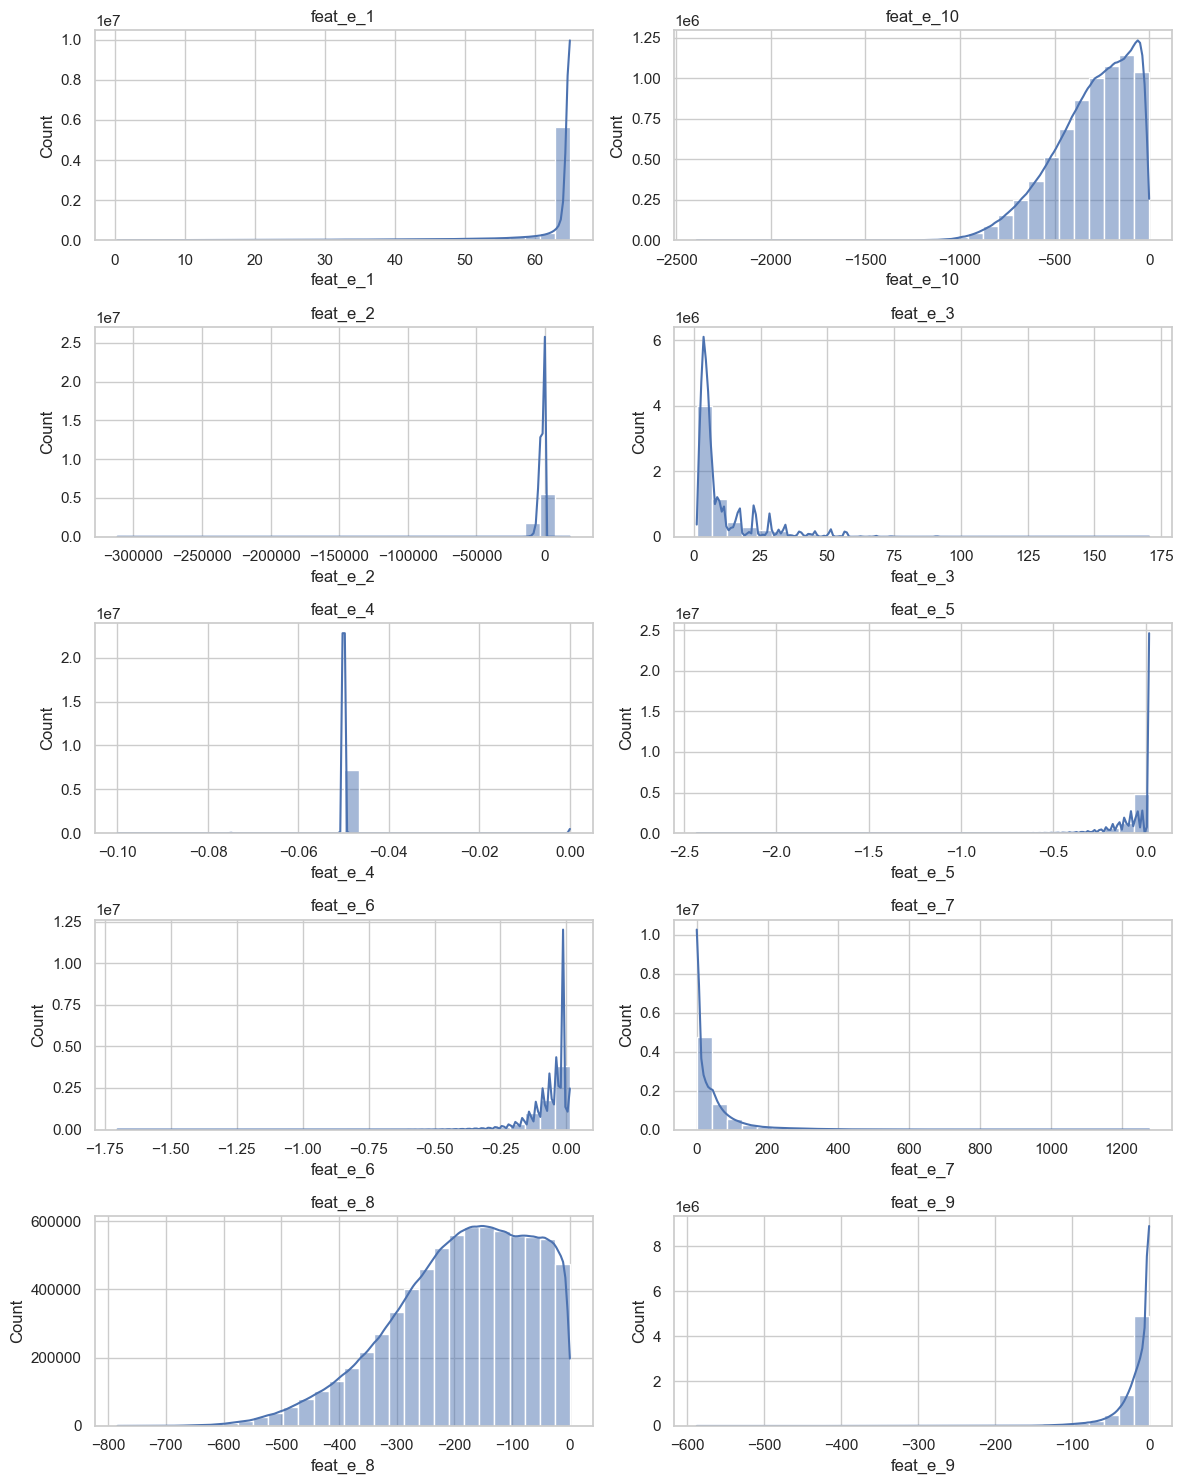

In [15]:
# 2. Histogram plots (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_e_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(f"{col}")
    plt.tight_layout()

plt.show()

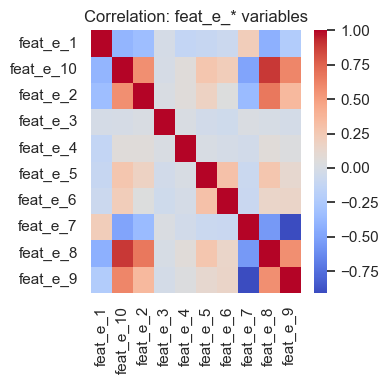

Highly correlated feat_e_* pairs (r > 0.8):
feat_e_10 ↔ feat_e_8: 0.890
feat_e_7 ↔ feat_e_9: 0.908


In [16]:
# 3. Correlation matrix and highly correlated pairs
import numpy as np

plt.figure(figsize=(4,4))
sns.heatmap(train_df[feat_e_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation: feat_e_* variables")
plt.tight_layout()
plt.show()

# Print only if strong correlation exists
corr_matrix = train_df[feat_e_cols].corr().abs()
np.fill_diagonal(corr_matrix.values, 0)

threshold = 0.8
high_corr = np.where(corr_matrix > threshold)
printed = set()

results = []
for i, j in zip(*high_corr):
    pair = tuple(sorted((corr_matrix.index[i], corr_matrix.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_matrix.iloc[i, j]))

if results:
    print("Highly correlated feat_e_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

In [17]:
clip_candidates = {'feat_e_2', 'feat_e_5'}  # extreme outliers
drop_candidates = {'feat_e_4'}              # constant or variance = 0
flag_candidates = {'feat_e_5'}             

### feat_e_* — summary & insights

- **Correlated pairs identified.** Some variable pairs (e.g., `feat_e_10` & `feat_e_8`, `feat_e_7` & `feat_e_9`) showed strong linear correlation. No action taken during baseline modeling, but candidates for pruning in model simplification stages.

- Note: Some features (e.g., `feat_e_2`, `feat_e_5`) showed extreme outliers, while others (e.g., `feat_e_4`) appeared near-constant. These were **flagged as transformation/drop candidates**, but no changes were applied at this stage. Instead, they will be reviewed **after analyzing all feat_* blocks**, and then evaluated via **cross-validated performance comparison** in the modeling phase.


[scikit-learn tree algorithms](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms)  
[XGBoost documentation](https://xgboost.readthedocs.io/en/stable/)


In [18]:
# feat_d_* features — summary, histograms, correlations
# Identify feat_d_* columns
feat_d_cols = sorted([c for c in train_df.columns if c.startswith("feat_d_")])

# 1. Summary statistics
train_df[feat_d_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
feat_d_1,7267221.0,0.362478,0.067697,0.000000,0.376623,0.389610,0.389610,0.389610
feat_d_2,7267221.0,1.616622,0.651316,0.000000,1.600000,1.933333,2.000000,2.000000
feat_d_3,7267221.0,1.475183,0.563508,0.000000,1.588235,1.764706,1.764706,1.764706
feat_d_4,7267221.0,9.272613,9.775568,0.000000,2.108108,6.000000,13.786047,78.000000
feat_d_5,7267221.0,-0.218764,0.116746,-0.303030,-0.303030,-0.292929,-0.111111,0.000000
feat_d_6,7267221.0,-0.297444,0.168529,-0.422535,-0.422535,-0.408451,-0.140845,0.000000


In [19]:
clip_candidates.update({'feat_d_4', 'feat_d_5', 'feat_d_6'})
flag_candidates.update({'feat_d_5', 'feat_d_6'})
drop_candidates.add('feat_d_1')


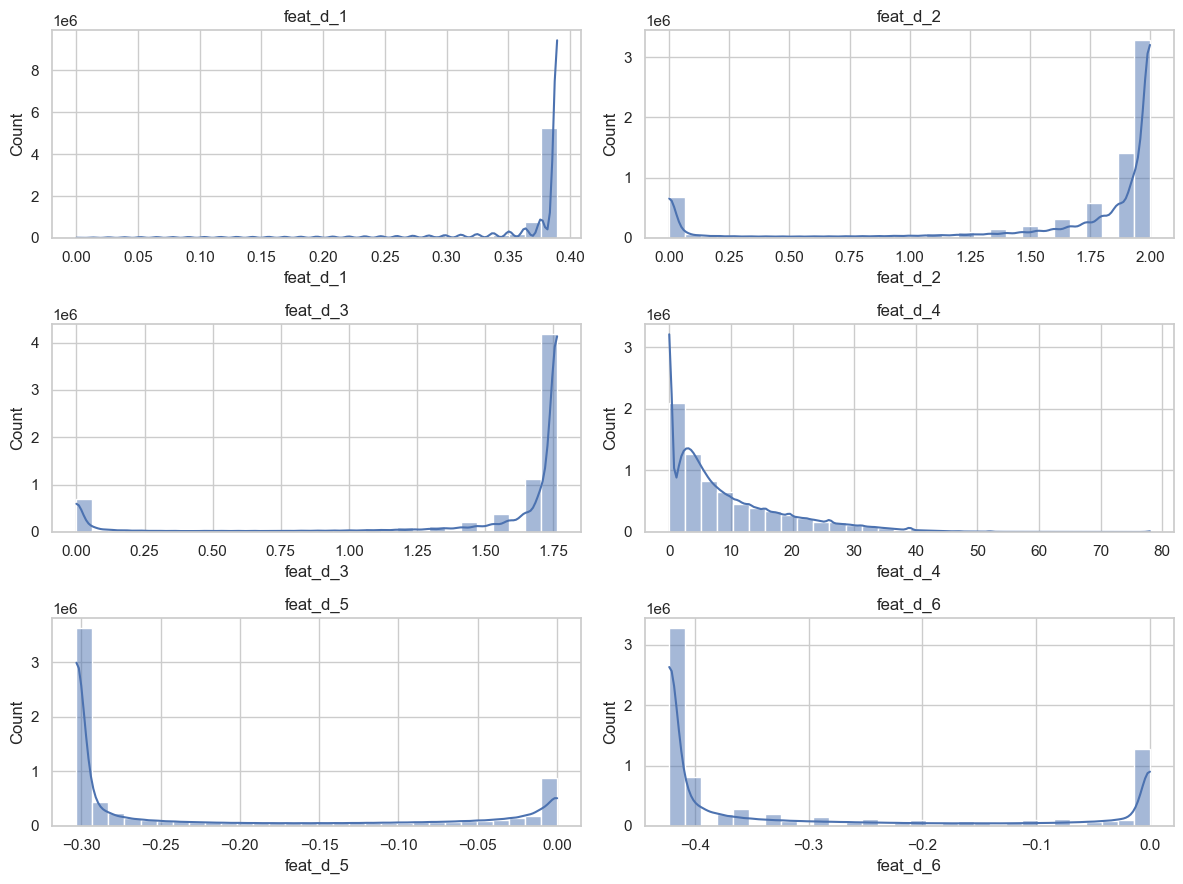

In [20]:
# 2. Histogram plots (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_d_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

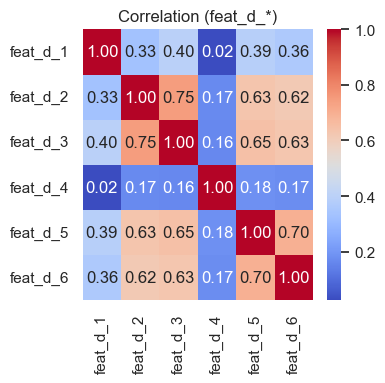

In [21]:
# 3. Correlation matrix and high-corr pairs
import numpy as np

corr_matrix = train_df[feat_d_cols].corr().abs()
plt.figure(figsize=(4,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (feat_d_*)")
plt.tight_layout()
plt.show()

# Print only if high correlation exists
np.fill_diagonal(corr_matrix.values, 0)
threshold = 0.8
high_corr = np.where(corr_matrix > threshold)
printed = set()
results = []

for i, j in zip(*high_corr):
    pair = tuple(sorted((corr_matrix.index[i], corr_matrix.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_matrix.iloc[i, j]))

if results:
    print("Highly correlated feat_d_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_d_* — summary, distribution, correlation

- All variables are **continuous**, with noticeable **skewness** in distribution 

- **Outliers:** `feat_d_4` shows a wide long tail (max=78, Q3=13.8). Added to `clip_candidates`.
- **Skewed distributions:** `feat_d_5`, `feat_d_6` have negative-heavy distributions. Flagged for clipping or outlier flagging.
- **Low variance:** `feat_d_1` is nearly constant (Q3=max=0.3896) → added to `drop_candidates`.


In [22]:
# feat_c_* features — summary, missing ratio, histograms, correlations
feat_c_cols = sorted([c for c in train_df.columns if c.startswith("feat_c_")])

# 1. Summary statistics
train_df[feat_c_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_c_1,7267221.0,53.782631,12.938353,0.0,56.784985,58.635109,58.778076,58.849396
feat_c_2,7267221.0,9.175218,14.670230,0.0,0.081644,0.480029,10.537893,35.999992
feat_c_3,7267221.0,52.858681,24.401094,0.0,31.975409,59.106060,75.238960,83.000000
feat_c_4,7267221.0,25.627396,6.006927,0.0,26.119205,28.134329,28.625807,29.000000
feat_c_5,7267221.0,35.208843,12.756646,0.0,28.447369,41.173553,44.647549,47.000000
feat_c_6,7267221.0,6.394741,2.174372,0.0,5.957447,7.437186,7.801460,8.000000
feat_c_7,7267221.0,68.595268,16.505381,0.0,73.776207,73.954559,73.959229,74.000000
feat_c_8,7267221.0,23.154470,8.413021,0.0,17.422222,26.412699,30.181053,32.000000


In [23]:
clip_candidates.add('feat_c_2')
drop_candidates.update({'feat_c_1', 'feat_c_4', 'feat_c_7'})


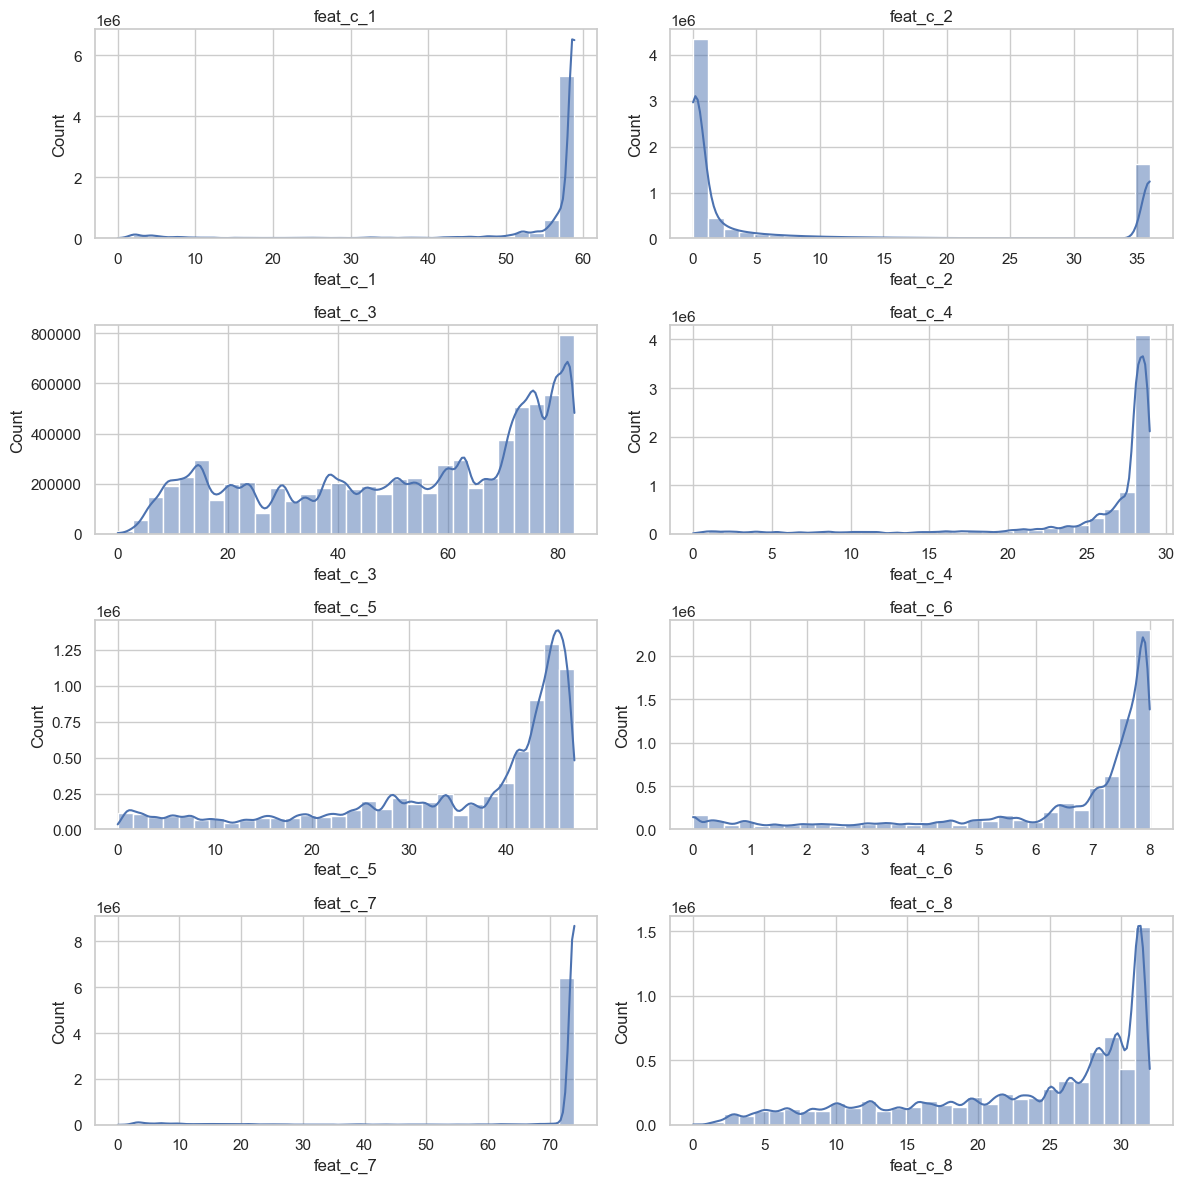

In [24]:
# 2. Histogram (2 plots per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_c_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

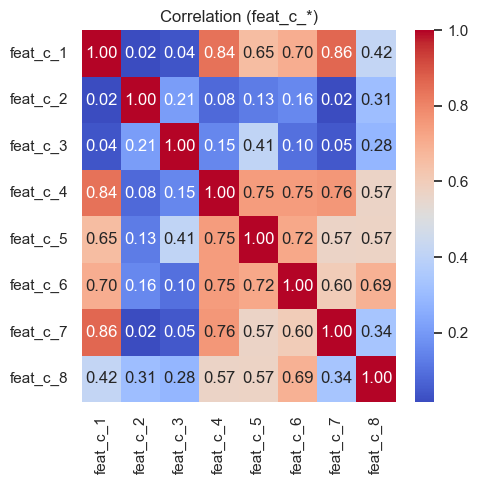

Highly correlated feat_c_* pairs (r > 0.8):
feat_c_1 ↔ feat_c_4: 0.840
feat_c_1 ↔ feat_c_7: 0.865


In [25]:
# 3. Correlation matrix and high-corr pairs
import numpy as np

corr_matrix = train_df[feat_c_cols].corr().abs()
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (feat_c_*)")
plt.tight_layout()
plt.show()

np.fill_diagonal(corr_matrix.values, 0)
threshold = 0.8
high_corr = np.where(corr_matrix > threshold)
printed = set()
results = []

for i, j in zip(*high_corr):
    pair = tuple(sorted((corr_matrix.index[i], corr_matrix.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_matrix.iloc[i, j]))

if results:
    print("Highly correlated feat_c_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_c_* — distribution and correlation insights

- **Near-constant features:**  
  `feat_c_1`, `feat_c_4`, and `feat_c_7` show extremely narrow distributions (Q3 ≈ max), indicating low variance.  
  → Added to `drop_candidates`.

- **Right-skewed feature:**  
  `feat_c_2` has a long right tail (Q3 = 10.5, max = 36).  
  → Added to `clip_candidates`.

- **High correlation detected:**  
  - `feat_c_1` ↔ `feat_c_4` (r = 0.84)  
  - `feat_c_1` ↔ `feat_c_7` (r = 0.87)  
  These may be redundant and subject to removal based on feature importance or SHAP analysis.


In [26]:
# feat_b_* features — summary, histograms, correlations

feat_b_cols = sorted([c for c in train_df.columns if c.startswith("feat_b_")])

# 1. Summary statistics
train_df[feat_b_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_b_1,7267221.0,4.600186,26.500998,0.000000,3.752577,4.340206,4.618556,2066.103027
feat_b_2,7267221.0,-2.915182,2.867076,-278.433746,-4.337349,-3.373494,-0.216867,0.000000
feat_b_3,7267221.0,24.007336,25.338337,0.000000,6.037037,17.833334,35.537037,1172.740723
feat_b_4,7267221.0,0.770263,0.294521,0.000000,0.804124,0.907216,0.927835,1.319588
feat_b_5,7267221.0,-45.836357,35.167763,-979.368408,-70.614037,-41.561405,-15.649123,0.000000
feat_b_6,7267221.0,1373.932861,1468.365845,0.000000,419.916656,1171.250000,2069.666748,86991.835938


In [27]:
clip_candidates.update({
    'feat_b_1', 'feat_b_2', 'feat_b_3',
    'feat_b_5', 'feat_b_6'
})
flag_candidates.update({
    'feat_b_1', 'feat_b_2', 'feat_b_3',
    'feat_b_5', 'feat_b_6'
})


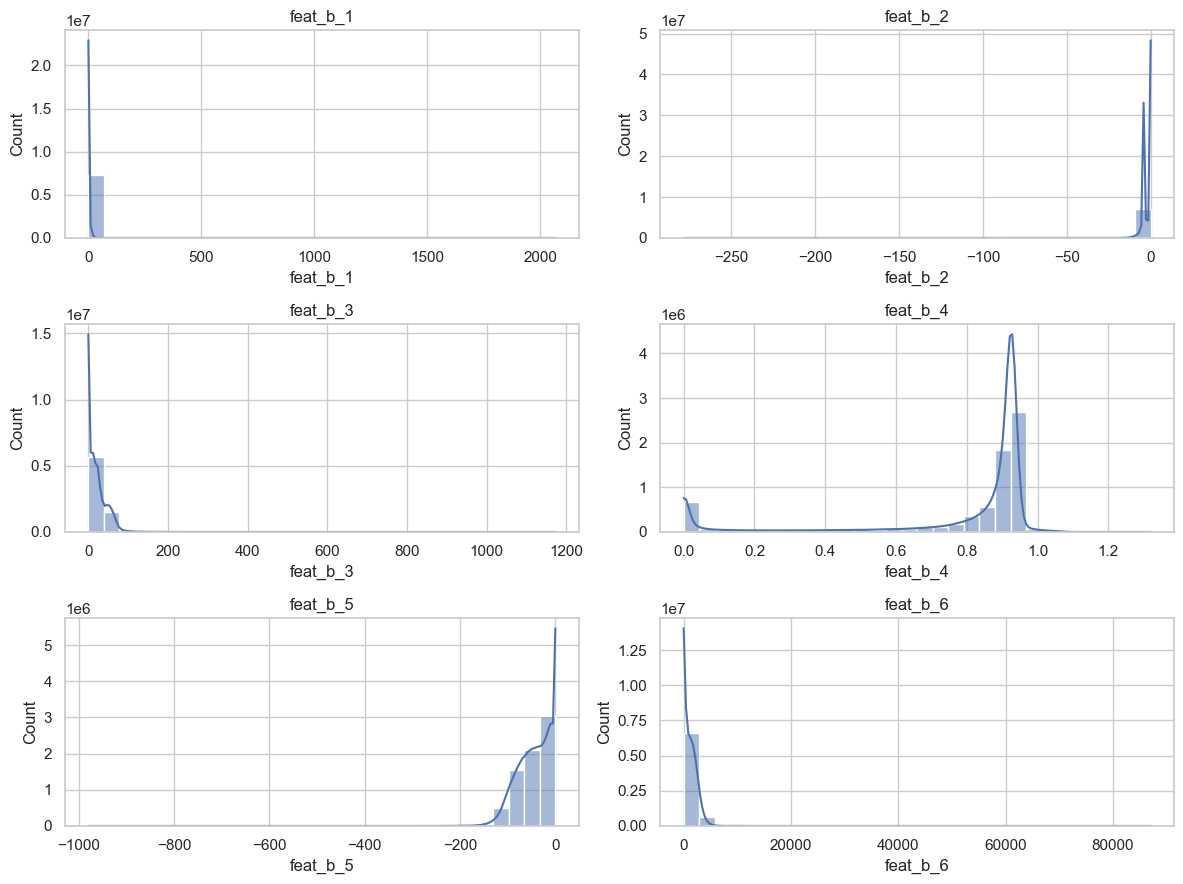

In [28]:
# 2. Histograms (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_b_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

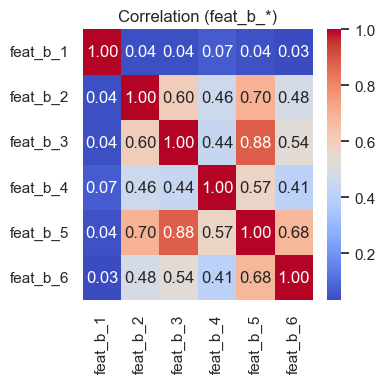

Highly correlated feat_b_* pairs (r > 0.8):
feat_b_3 ↔ feat_b_5: 0.880


In [29]:
# 3. Correlation analysis and high-corr pairs
import numpy as np

corr_b = train_df[feat_b_cols].corr().abs()
plt.figure(figsize=(4, 4))
sns.heatmap(corr_b, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (feat_b_*)")
plt.tight_layout()
plt.show()

np.fill_diagonal(corr_b.values, 0)
threshold = 0.8
high = np.where(corr_b > threshold)
printed = set()
results = []

for i, j in zip(*high):
    pair = tuple(sorted((corr_b.index[i], corr_b.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_b.iloc[i, j]))

if results:
    print("Highly correlated feat_b_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_b_* — distribution & correlation insights

- **Extreme outliers detected:**  
  - `feat_b_1`, `feat_b_3`, `feat_b_6` have long right tails (e.g., max=2066 to 86,992)  
  - `feat_b_2`, `feat_b_5` have long left tails with negative spikes (min=−278 to −979)  
  → All added to both `clip_candidates` and `flag_candidates` for downstream evaluation.

- **Moderate distribution:**  
  - `feat_b_4` shows slightly skewed values (Q3=0.93, max=1.31) but no severe outliers.  
  → Retained without modification.
  
- feat_b_3 and feat_b_5 are **highly correlated (r = 0.88)**. One of them may be dropped if multicollinearity affects performance later.

In [30]:
# feat_a_* features — summary, histograms, correlations

feat_a_cols = sorted([c for c in train_df.columns if c.startswith("feat_a_")])
# 1. Summary statistics
train_df[feat_a_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_a_1,7266266.0,1.678955,4.539063,0.0,0.0000,0.0000,0.000000,14.400000
feat_a_10,7266266.0,3.632380,16.045004,0.0,0.0000,0.0000,0.000000,76.500000
feat_a_11,7266266.0,1.229338,6.195090,0.0,0.0000,0.0000,0.000000,37.799999
feat_a_12,7266266.0,0.545580,2.238668,0.0,0.0000,0.0000,0.000000,14.000000
feat_a_13,7266266.0,1.386370,5.293330,0.0,0.0000,0.0000,0.000000,47.700001
feat_a_14,7266266.0,3.255992,2.066454,0.0,1.6674,2.9029,3.834600,7.000000
feat_a_15,7266266.0,5.024750,14.605459,0.0,0.0000,0.0000,0.000000,62.099998
feat_a_16,7266266.0,0.670997,3.099230,0.0,0.0000,0.0000,0.000000,18.900000
feat_a_17,7266266.0,0.208677,0.590755,0.0,0.0000,0.0000,0.000000,3.600000
feat_a_18,7266266.0,4.392399,13.303791,0.0,0.0000,0.0000,0.000000,47.700001


In [31]:
clip_candidates.update({
    'feat_a_1', 'feat_a_3', 'feat_a_4', 'feat_a_7', 'feat_a_8',
    'feat_a_9', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13',
    'feat_a_15', 'feat_a_16', 'feat_a_18'
})
flag_candidates.update(clip_candidates)


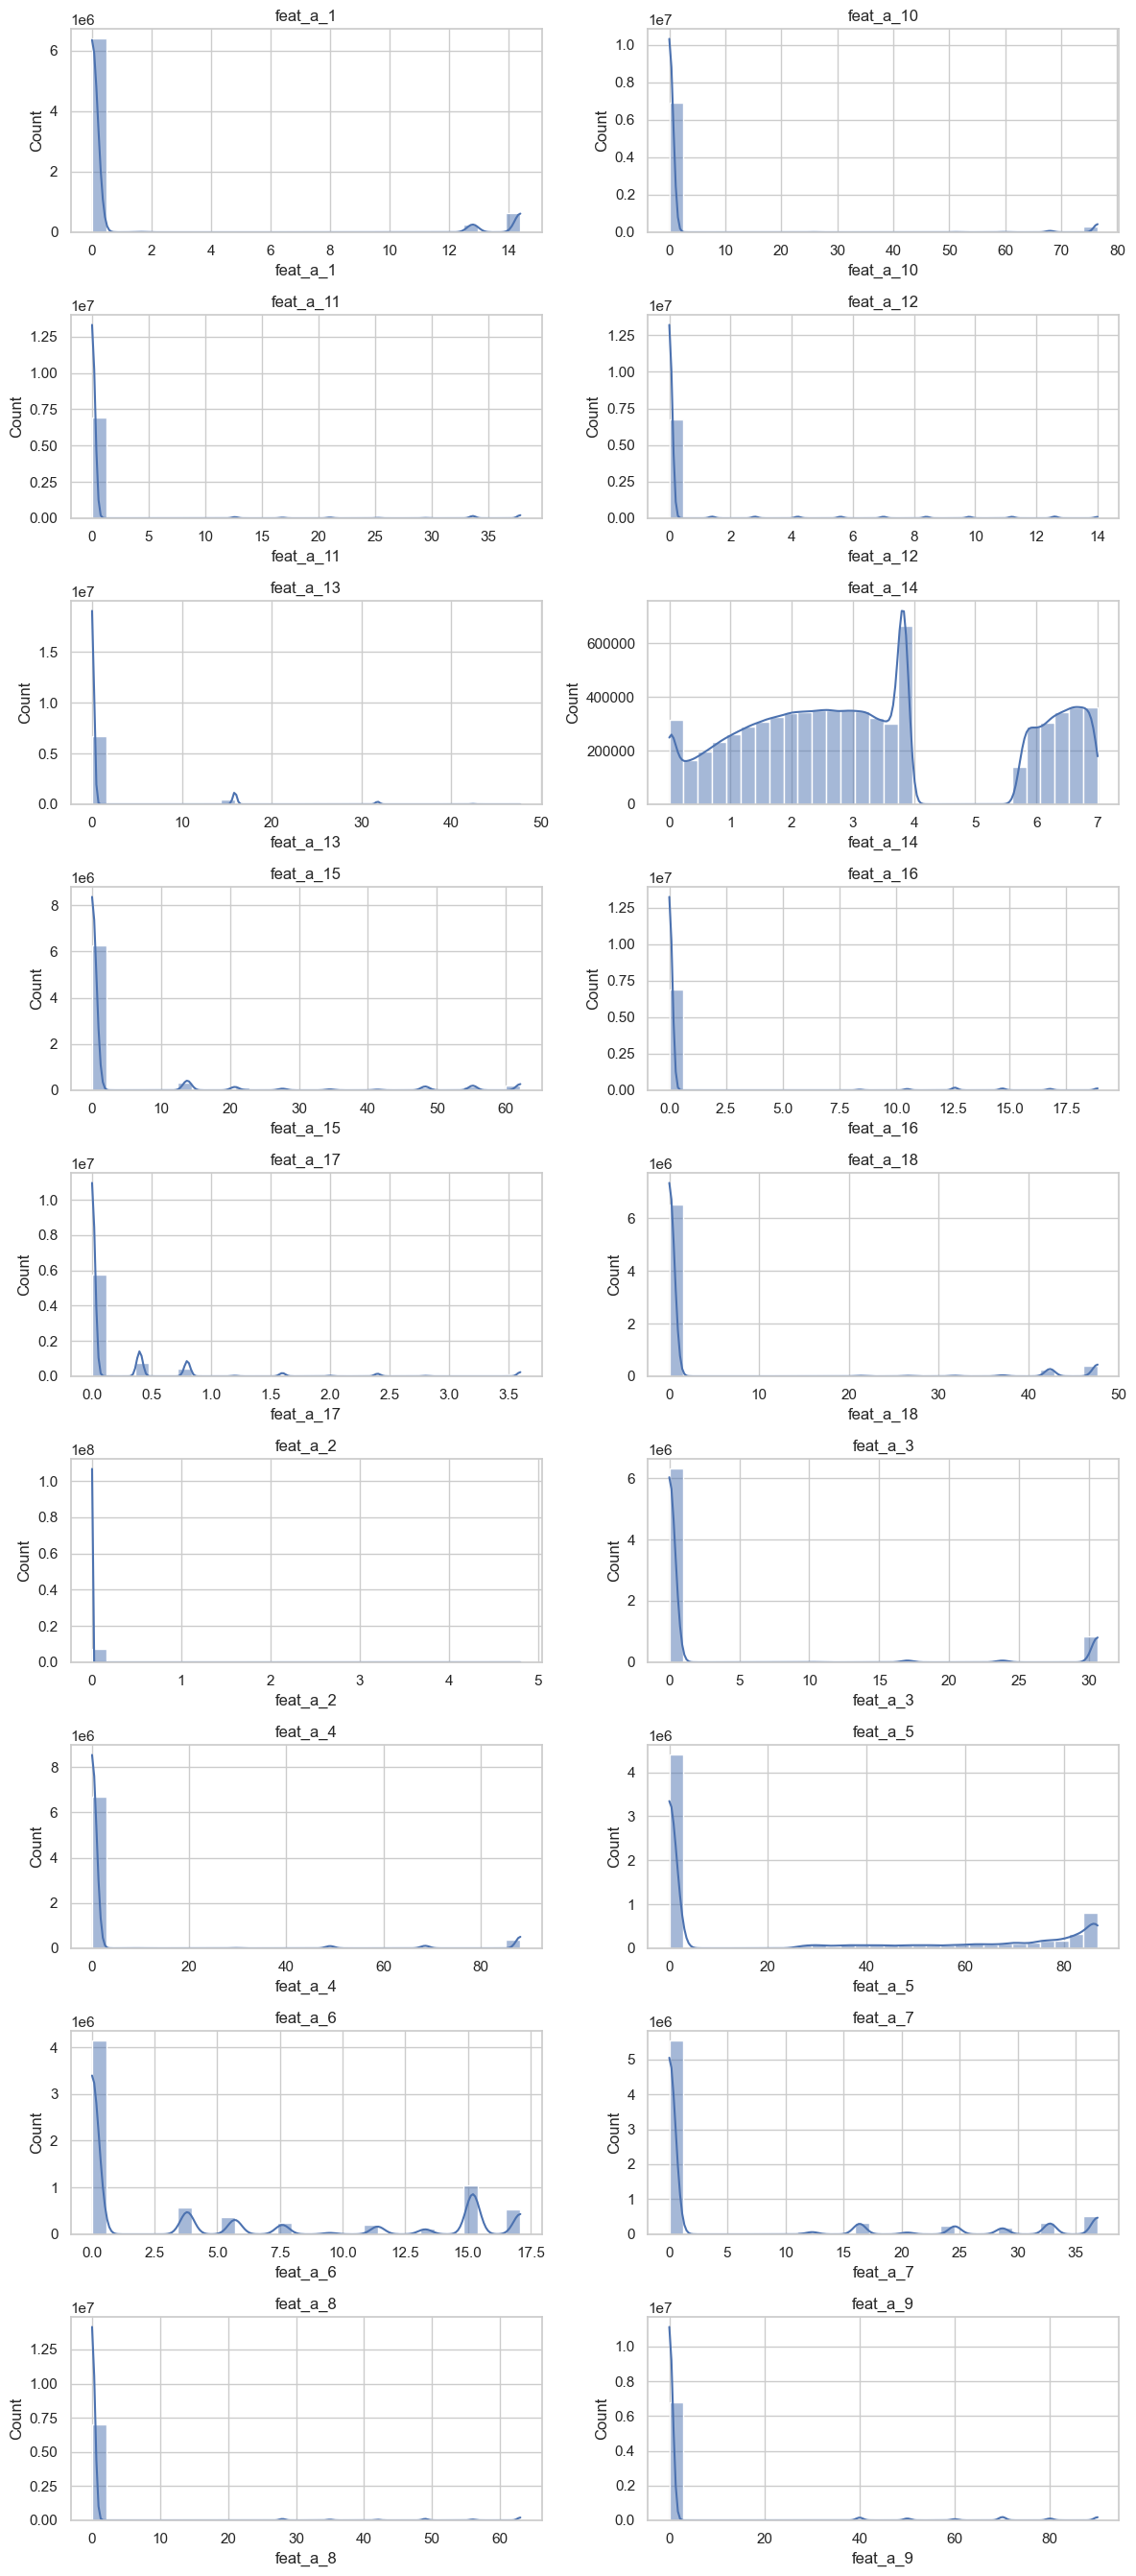

In [32]:
# 2. Histograms (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_a_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

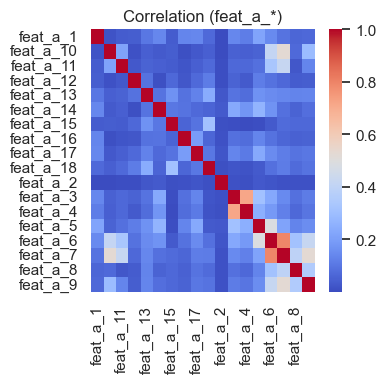

In [33]:
# 3. Correlation analysis and high-corr pairs
import numpy as np

corr_a = train_df[feat_a_cols].corr().abs()
plt.figure(figsize=(4,4))
sns.heatmap(corr_a, annot=False, cmap="coolwarm")
plt.title("Correlation (feat_a_*)")
plt.tight_layout()
plt.show()

np.fill_diagonal(corr_a.values, 0)
threshold = 0.8
high = np.where(corr_a > threshold)
printed = set()
results = []

for i, j in zip(*high):
    pair = tuple(sorted((corr_a.index[i], corr_a.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_a.iloc[i, j]))

if results:
    print("Highly correlated feat_a_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_a_* — distribution insights

- **Zero-heavy features.**  
Most feat_a_* (e.g., a_1~a_13, a_15~a_18) are zero-inflated, indicating potentially sparse usage or missing-like patterns. No transformation applied due to tree-based model robustness.

- **Suspicious empty region.**  
feat_a_14 shows a clear gap between ~4.0–5.6; this may suggest censored or structurally missing values. Will investigate if it corresponds to a masked value or encoding error.

- **Sparse + long-tailed distributions:**  
  Many `feat_a_*` features are zero-inflated with heavy right tails (e.g., `feat_a_4`, `feat_a_9`, `feat_a_15`).  
  → Added to both `clip_candidates` and `flag_candidates` for downstream handling.



In [34]:
# history_a_* features — summary, histograms, correlations
history_a_cols = [c for c in train_df.columns if c.startswith("history_a_")]
# 1. Summary statistics
train_df[history_a_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
history_a_1,7267221.0,0.113698,0.384817,0.000000,0.028232,0.049880,0.092810,18.709814
history_a_2,7267221.0,-0.110267,0.272374,-58.611111,-0.111111,-0.055556,0.000000,0.000000
history_a_3,7267221.0,0.049477,0.110528,0.000000,0.012195,0.024390,0.060976,20.975609
history_a_4,7267221.0,-348.962189,300.973938,-7754.714355,-497.714294,-279.857147,-124.000000,0.000000
history_a_5,7267221.0,-0.014998,0.038401,-7.913043,-0.014493,0.000000,0.000000,0.000000
history_a_6,7267221.0,-172.511978,148.100327,-3826.857178,-245.285721,-139.285721,-62.000000,0.000000
history_a_7,7267221.0,-12.088017,10.408539,-235.596161,-17.230770,-9.750000,-4.288462,0.000000


In [35]:
clip_candidates.update({
    'history_a_1', 'history_a_2', 'history_a_3', 'history_a_4',
    'history_a_5', 'history_a_6', 'history_a_7'
})
flag_candidates.update(clip_candidates)


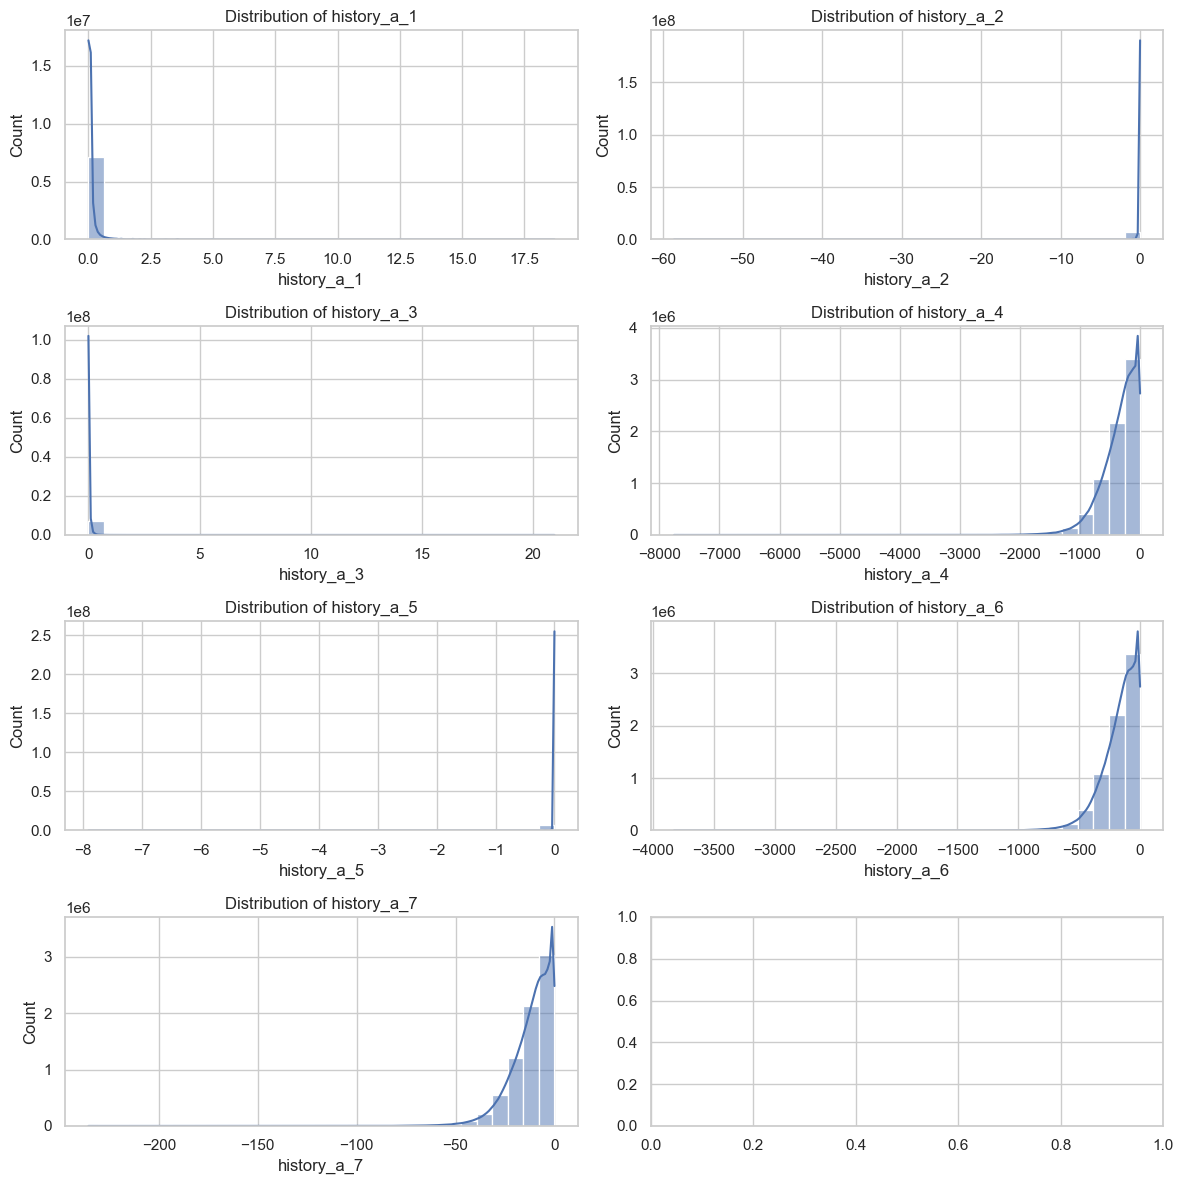

In [36]:
# 2. Histogram of each feature
import matplotlib.pyplot as plt
import seaborn as sns

n = len(history_a_cols)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for i, col in enumerate(history_a_cols):
    sns.histplot(data=train_df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

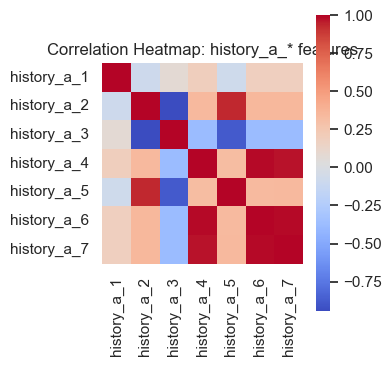

In [37]:
# Correlation heatmap
import numpy as np

corr_matrix = train_df[history_a_cols].corr()
plt.figure(figsize=(4,4))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap: history_a_* features")
plt.tight_layout()
plt.show()

### history_a_* — distribution summary & handling plan

- **Heavily skewed distributions.**  
  All `history_a_*` features are either right- or left-skewed. No transformations applied, as tree-based models (e.g., LGBM) are robust to such distributions.

- **Extreme outliers (both tails).**  
  - `history_a_1`, `a_2`, `a_3`: right-skewed with rare but large positive values  
  - `history_a_4`, `a_6`, `a_7`: negatively skewed, large outliers on the left  
  - `history_a_5`: bounded near 0 but min ≈ −7.9 suggests noise risk  
  → All added to `clip_candidates` and `flag_candidates` for optional denoising.

- **Potential redundancy.**  
  - `history_a_4`, `a_6`, `a_7` show high correlation.  
  If their SHAP importance is also redundant, low-ranked features among them may be dropped to reduce model complexity.



In [38]:
# history_b_* features — summary, histograms, correlations

# identify columns
history_b_cols = [c for c in train_df.columns if c.startswith("history_b_")]

# 1. summary table
display(train_df[history_b_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
history_b_1,7267221.0,0.428113,1.337154,0.0,0.081348,0.144451,0.285913,41.0
history_b_2,7267221.0,0.603773,2.074313,0.0,0.126780,0.225028,0.429950,89.0
history_b_3,7267221.0,0.309690,1.353260,0.0,0.040614,0.071931,0.156007,30.5
history_b_4,7267221.0,0.319471,1.436866,0.0,0.038876,0.068419,0.151866,32.5
history_b_5,7267221.0,0.167610,0.752342,0.0,0.020397,0.036094,0.080189,17.0
history_b_6,7267221.0,0.009773,0.044202,0.0,0.001167,0.002053,0.004587,1.0
history_b_7,7267221.0,0.156822,0.707743,0.0,0.018845,0.033194,0.073904,16.0
history_b_8,7267221.0,0.323767,1.458916,0.0,0.039237,0.068963,0.153133,33.0
history_b_9,7267221.0,0.030130,0.132996,0.0,0.003867,0.006826,0.014926,3.0
history_b_10,7267221.0,0.153274,0.609564,0.0,0.025164,0.044777,0.090604,18.0


In [39]:
clip_candidates.update(['history_b_1', 'history_b_2', 'history_b_11', 'history_b_16', 'history_b_22', 'history_b_23'])


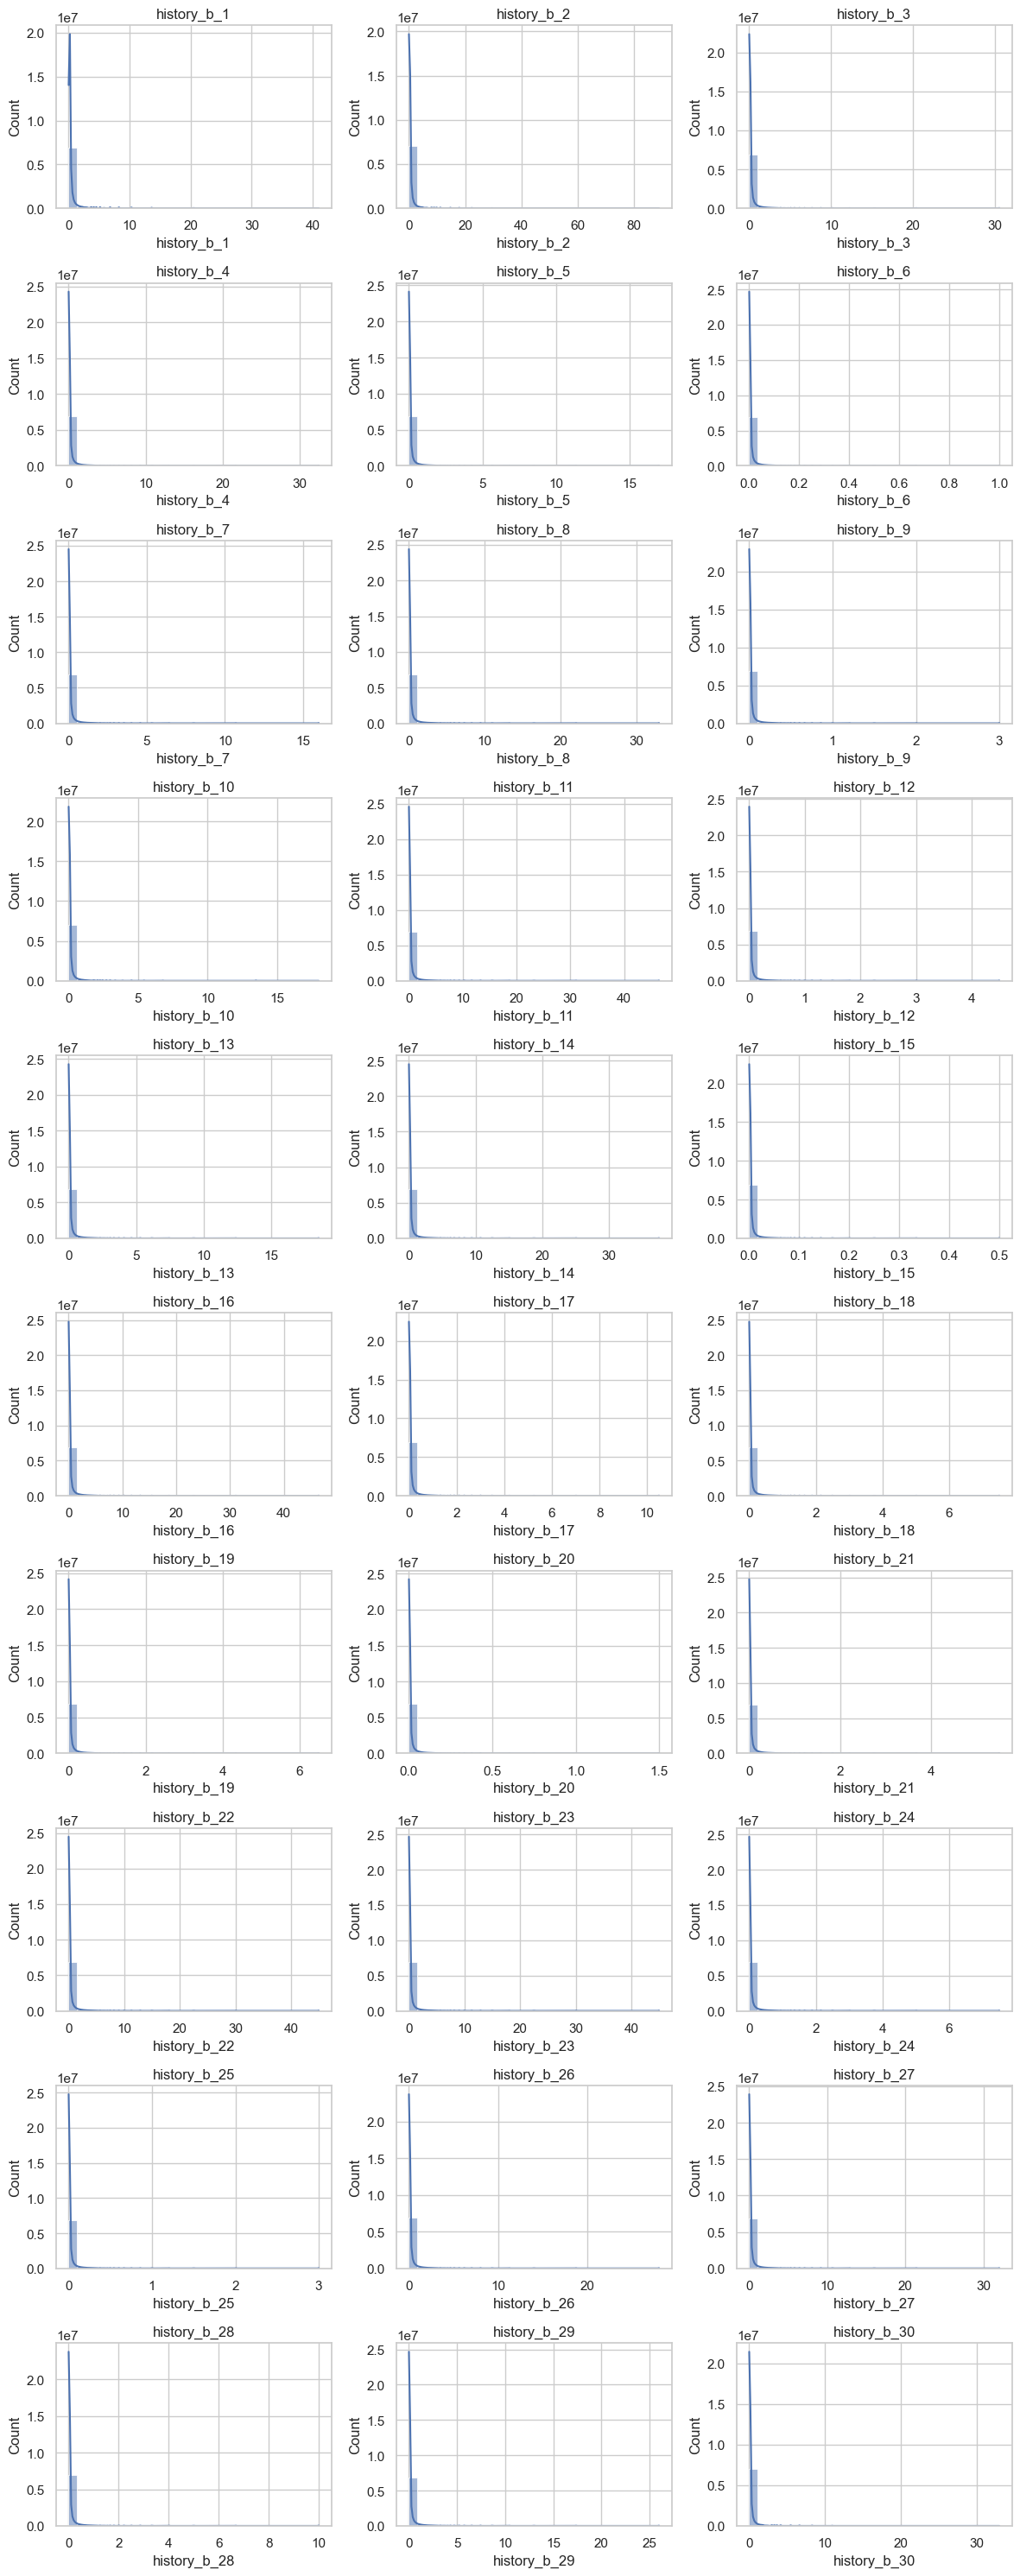

In [40]:
# 2. histograms (3 per row)
import matplotlib.pyplot as plt
import seaborn as sns

n = len(history_b_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for i, col in enumerate(history_b_cols):
    sns.histplot(train_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

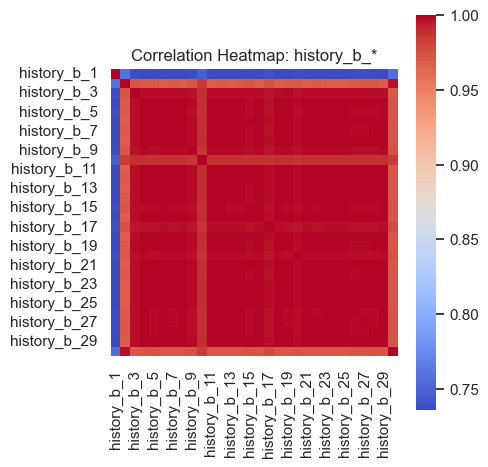

In [41]:
# 3. correlation heatmap
corr_matrix = train_df[history_b_cols].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", square=True)
plt.title("Correlation Heatmap: history_b_*")
plt.tight_layout()
plt.show()

### Distribution & Correlation Analysis: `history_b_*`

Most `history_b_*` features show highly right-skewed distributions with long tails and zero-heavy peaks. Despite being numerous, their distributions are nearly identical in shape and scale.

The correlation heatmap confirms strong multicollinearity among them, with pairwise correlations exceeding 0.95 in many cases. This suggests these variables carry largely redundant information.

→ Dimensionality reduction or representative feature selection (e.g., VIF filtering or PCA) could be considered to mitigate potential collinearity issues during modeling.

------

### Remove extremely correlated features (Pearson r ≥ 0.995 or Cramér's V ≈ 1)

To reduce redundancy and improve training efficiency, features with extremely high **Pearson correlation** (|r| ≥ 0.995, p < 0.01) and **Cramér's V** (V ≈ 1) were dropped.  
While XGBoost/LightGBM are generally robust to multicollinearity, this reduction was applied due to the large dataset size (~10M rows), where such redundancies can inflate computation and reduce model clarity.

- Sampled 1M rows for fast computation.
- Drop decision rule: higher missing rate or lower variance/cardinality.

In [42]:
# Identify extremely correlated numeric feature pairs using Pearson's r.
# Remove near-duplicate pairs (|r| ≥ 0.995 and p < 0.01) to reduce redundancy and improve efficiency.
import numpy as np
import pandas as pd

# === Configurations ===
R_THRESH = 0.995           # absolute Pearson correlation threshold
SAMPLE_N = 1_000_000       # sample size for speed-up

# Select only numeric columns
num_cols = [c for c in train_df.columns if pd.api.types.is_numeric_dtype(train_df[c])]
df_num = train_df[num_cols]
if SAMPLE_N is not None and len(df_num) > SAMPLE_N:
    df_num = df_num.sample(SAMPLE_N, random_state=42)
corr_abs = df_num.corr().abs()
mask = np.triu(np.ones_like(corr_abs, dtype=bool), k=1)
high_corr = corr_abs.where(mask) >= R_THRESH
to_drop_num = set()
for i, col_i in enumerate(high_corr.columns):
    for j, col_j in enumerate(high_corr.index):
        if high_corr.iloc[j, i]:
            na_i = train_df[col_i].isna().mean()
            na_j = train_df[col_j].isna().mean()
            if na_i > na_j:
                drop = col_i
            elif na_j > na_i:
                drop = col_j
            else:
                var_i = train_df[col_i].var()
                var_j = train_df[col_j].var()
                drop = col_i if var_i < var_j else col_j
            to_drop_num.add(drop)
for df in (train_df, valid_df, holdout_df):
    df.drop(columns=[c for c in to_drop_num if c in df.columns], errors='ignore', inplace=True)

In [43]:
from pandas.api.types import CategoricalDtype

# Detect perfect or alias categorical feature pairs using bias-corrected Cramér's V (V ≈ 1).
# Drop redundant columns to eliminate exact categorical duplicates.
# settings
SAMPLE_N = 1_000_000        # large random sample for speed; set None for full
MAX_CARD = 50               # skip very high-card pairs
ALPHA = 0.01                # kept for consistency (not used here since V≈1 only)

# collect categorical l_feat_* candidates
lfeat_numeric = {"l_feat_5","l_feat_6","l_feat_7","l_feat_9","l_feat_10",
                 "l_feat_11","l_feat_12","l_feat_14","l_feat_15"}
lfeat_all = [c for c in train_df.columns if c.startswith("l_feat_")]
lfeat_cats = [c for c in lfeat_all if c not in lfeat_numeric]

# sample rows for speed
df_cv = train_df[lfeat_cats].copy()
if SAMPLE_N is not None and len(df_cv) > SAMPLE_N:
    df_cv = df_cv.sample(SAMPLE_N, random_state=42)

# ensure category dtype (lightweight)
for c in lfeat_cats:
    if not isinstance(df_cv[c].dtype, CategoricalDtype):
        try:
            df_cv[c] = df_cv[c].astype("Float64").round().astype("Int64").astype("category")
        except Exception:
            df_cv[c] = df_cv[c].astype("category")

def is_perfect_mapping(a: pd.Series, b: pd.Series, max_card: int) -> bool:
    """Return True if a↔b is one-to-one (perfect association) on non-null rows."""
    m = a.notna() & b.notna()
    a, b = a[m], b[m]
    ua, ub = a.nunique(), b.nunique()
    if ua == 0 or ub == 0 or ua > max_card or ub > max_card:
        return False
    # each level of a maps to exactly one level of b AND vice versa
    return (a.groupby(a).transform("size").shape[0] > 0 and
            a.groupby(a).apply(lambda x: b.loc[x.index].nunique()).max() == 1 and
            b.groupby(b).apply(lambda x: a.loc[x.index].nunique()).max() == 1)

pairs, to_drop = [], set()

# quick screen using codes equality to catch obvious duplicates cheaply
codes = {c: df_cv[c].cat.codes.values for c in lfeat_cats}

for i, a in enumerate(lfeat_cats):
    for b in lfeat_cats[i+1:]:
        # ultra-fast equality shortcut (exact same partition)
        ac, bc = codes[a], codes[b]
        mask = (ac != -1) & (bc != -1)
        same_partition = False
        if mask.any():
            amap, bmap, ok = {}, {}, True
            for x, y in zip(ac[mask], bc[mask]):
                if x in amap and amap[x] != y: ok = False; break
                if y in bmap and bmap[y] != x: ok = False; break
                amap[x] = y; bmap[y] = x
            same_partition = ok
        if same_partition or is_perfect_mapping(df_cv[a], df_cv[b], MAX_CARD):
            pairs.append((a, b))

# choose which one to drop (more missingness, else higher cardinality, else name)
for a, b in pairs:
    na_a = train_df[a].isna().mean()
    na_b = train_df[b].isna().mean()
    if na_a != na_b:
        drop = a if na_a > na_b else b
    else:
        ca, cb = train_df[a].nunique(dropna=True), train_df[b].nunique(dropna=True)
        if ca != cb:
            drop = a if ca > cb else b      # keep lower-cardinality
        else:
            drop = max(a, b)                # tie-break by name
    to_drop.add(drop)

print("Perfect/alias categorical pairs found:", len(pairs))
print("Columns to drop:", sorted(to_drop))

for df in (train_df, valid_df, holdout_df):
    df.drop(columns=list(to_drop), errors='ignore', inplace=True)


Perfect/alias categorical pairs found: 1
Columns to drop: ['l_feat_16']


In [44]:
# clean candidates
clip_candidates = {c for c in clip_candidates if c in train_df.columns}
drop_candidates = {c for c in drop_candidates if c in train_df.columns}
flag_candidates = {c for c in flag_candidates if c in train_df.columns}


In [47]:
# =========================
# Experiment pipeline (clip vs. drop vs. flag vs. baseline)
# ===============================

from dataclasses import dataclass
from typing import Dict, Iterable, Tuple, List
import numpy as np
import pandas as pd

# Models & metrics
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import lightgbm as lgb
# import xgboost as xgb  # optional: enable if you want XGBoost experiments

RANDOM_STATE = 42

# -------- Utility: identify columns --------
TARGET_COL = "clicked"

EXCLUDE_FOR_MODEL = {"seq"}  

def split_Xy(df: pd.DataFrame, target: str = "clicked") -> Tuple[pd.DataFrame, pd.Series]:
    """Return X, y without mutating the input df. Excludes EXCLUDE_FOR_MODEL columns from X."""
    y = df[target].astype(int)
    cols = [c for c in df.columns if c not in EXCLUDE_FOR_MODEL and c != target]
    X = df[cols]
    return X, y

manual_cat_cols = [
    "gender", "age_group", "inventory_id", "day_of_week", "hour",
    'l_feat_1','l_feat_2','l_feat_3','l_feat_4','l_feat_8','l_feat_13',
    'l_feat_16','l_feat_18','l_feat_19','l_feat_20','l_feat_21',
    'l_feat_22','l_feat_23','l_feat_24','l_feat_26','l_feat_27'
]

for df in [train_df, valid_df, holdout_df]:
    for col in manual_cat_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")


def get_col_groups(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Return (numeric_cols, categorical_cols) based on pandas dtypes."""
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != TARGET_COL]
    cat_cols = [c for c in df.columns if str(df[c].dtype) == "category"]
    # Remove any overlap (in case target is categorical or mis-typed)
    num_cols = [c for c in num_cols if c not in cat_cols and c != TARGET_COL]
    cat_cols = [c for c in cat_cols if c != TARGET_COL]
    return num_cols, cat_cols

# -------- Outlier clipping & flagging --------
def compute_clip_thresholds(
    df: pd.DataFrame, cols: Iterable[str], lower_q: float = 0.01, upper_q: float = 0.99
) -> Dict[str, Tuple[float, float]]:
    """Compute per-column (lower, upper) percentile thresholds for clipping."""
    thresholds = {}
    for c in cols:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            lo, hi = df[c].quantile([lower_q, upper_q]).values
            thresholds[c] = (float(lo), float(hi))
    return thresholds

def apply_clipping_inplace(df: pd.DataFrame, thresholds: Dict[str, Tuple[float, float]]) -> None:
    """Clip numeric columns in place based on provided thresholds."""
    for c, (lo, hi) in thresholds.items():
        if c in df.columns:
            df[c] = df[c].clip(lower=lo, upper=hi)

def add_outlier_flags_inplace(df: pd.DataFrame, thresholds: Dict[str, Tuple[float, float]]) -> None:
    """Add binary outlier flags for values outside [lo, hi]."""
    for c, (lo, hi) in thresholds.items():
        if c in df.columns:
            flag_col = f"{c}_outlier_flag"
            df[flag_col] = ((df[c] < lo) | (df[c] > hi)).astype("int8")

# -------- Dataset builders for each variant --------
@dataclass
class BuildConfig:
    do_clip: bool = False
    do_drop: bool = False
    do_flag: bool = False
    lower_q: float = 0.01
    upper_q: float = 0.99

def build_variant(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    df_hold: pd.DataFrame,
    clip_cols: Iterable[str],
    drop_cols: Iterable[str],
    flag_cols: Iterable[str],
    cfg: BuildConfig
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Build dataset variants in a copy-safe manner.
    Operations order: Drop -> Clip -> Flag (on remaining columns).
    """
    tr, va, ho = df_train.copy(), df_valid.copy(), df_hold.copy()

    # 1) Drop near-constant or alias columns (if enabled)
    if cfg.do_drop:
        cols_to_drop = [c for c in drop_cols if c in tr.columns]
        for df_ in (tr, va, ho):
            df_.drop(columns=cols_to_drop, errors="ignore", inplace=True)

    # 2) Clip extreme outliers on the configured columns (if enabled)
    if cfg.do_clip:
        cols_for_clip = [c for c in clip_cols if c in tr.columns and pd.api.types.is_numeric_dtype(tr[c])]
        thresholds = compute_clip_thresholds(tr, cols_for_clip, cfg.lower_q, cfg.upper_q)
        apply_clipping_inplace(tr, thresholds)
        apply_clipping_inplace(va, thresholds)
        apply_clipping_inplace(ho, thresholds)
    else:
        thresholds = {}

    # 3) Add outlier flags (if enabled)
    if cfg.do_flag:
        cols_for_flag = [c for c in flag_cols if c in tr.columns and pd.api.types.is_numeric_dtype(tr[c])]
        # If clip is off, compute thresholds only for flagging
        if not cfg.do_clip:
            thresholds = compute_clip_thresholds(tr, cols_for_flag, cfg.lower_q, cfg.upper_q)
        add_outlier_flags_inplace(tr, thresholds)
        add_outlier_flags_inplace(va, thresholds)
        add_outlier_flags_inplace(ho, thresholds)

    return tr, va, ho

# -------- Model trainers --------
def compute_scale_pos_weight(y: pd.Series) -> float:
    """Return neg/pos ratio for scale_pos_weight."""
    pos = float((y == 1).sum())
    neg = float((y == 0).sum())
    return (neg / pos) if pos > 0 else 1.0

def make_lgbm_classifier(num_leaves: int = 64, learning_rate: float = 0.05, n_estimators: int = 1000, random_state: int = RANDOM_STATE) -> lgb.LGBMClassifier:
    """Create a LightGBM classifier with sensible defaults for CTR-like data."""
    return lgb.LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=random_state,
        n_jobs=-1,
        verbosity=-1,
    )

# Optional: XGBoost version (uncomment to use)
# def make_xgb_classifier(learning_rate: float = 0.05, n_estimators: int = 1000, random_state: int = RANDOM_STATE) -> xgb.XGBClassifier:
#     return xgb.XGBClassifier(
#         objective="binary:logistic",
#         tree_method="hist",
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=8,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_lambda=1.0,
#         random_state=random_state,
#         n_jobs=-1,
#         enable_categorical=True  # requires integer-encoded categories
#     )

def train_and_eval_lgbm(train_df: pd.DataFrame, valid_df: pd.DataFrame) -> Tuple[lgb.LGBMClassifier, Dict[str, float]]:
    """
    Train LightGBM on (train_df) and evaluate on (valid_df).
    Automatically handles pandas 'category' dtype as categorical features.
    """
    X_tr, y_tr = split_Xy(train_df)
    X_va, y_va = split_Xy(valid_df)

    # Detect numeric & categorical columns
    num_cols, cat_cols = get_col_groups(train_df)

    # Build LightGBM model
    spw = compute_scale_pos_weight(y_tr)
    model = make_lgbm_classifier()
    model.set_params(scale_pos_weight=spw)

    # LightGBM can consume pandas categorical columns directly.
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="binary_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=100,  verbose=False),
                   lgb.log_evaluation(period=0)]
    )

    # Predictions
    p_va = model.predict_proba(X_va)[:, 1]

    # Metrics
    metrics = {
        "logloss": log_loss(y_va, p_va),
        "roc_auc": roc_auc_score(y_va, p_va),
        "pr_auc": average_precision_score(y_va, p_va)
    }
    return model, metrics

# -------- Run experiments --------
def run_experiments(
    base_train: pd.DataFrame,
    base_valid: pd.DataFrame,
    base_hold: pd.DataFrame,
    clip_candidates: Iterable[str],
    drop_candidates: Iterable[str],
    flag_candidates: Iterable[str],
    lower_q: float = 0.01,
    upper_q: float = 0.99
) -> pd.DataFrame:
    """
    Build and evaluate variants:
      - Baseline
      - Clip
      - Drop
      - Flag
      - Clip+Drop
    Returns a results DataFrame sorted by PR-AUC (descending).
    """
    variants = {
        "baseline": BuildConfig(do_clip=False, do_drop=False, do_flag=False),
        "clip":     BuildConfig(do_clip=True,  do_drop=False, do_flag=False, lower_q=lower_q, upper_q=upper_q),
        "drop":     BuildConfig(do_clip=False, do_drop=True,  do_flag=False),
        "flag":     BuildConfig(do_clip=False, do_drop=False, do_flag=True,  lower_q=lower_q, upper_q=upper_q),
        "clip+drop":BuildConfig(do_clip=True,  do_drop=True,  do_flag=False, lower_q=lower_q, upper_q=upper_q),
        # Optional combos:
        # "clip+flag": BuildConfig(do_clip=True, do_drop=False, do_flag=True, lower_q=lower_q, upper_q=upper_q),
        # "all":       BuildConfig(do_clip=True, do_drop=True, do_flag=True, lower_q=lower_q, upper_q=upper_q),
    }

    rows = []
    trained_models = {}

    for name, cfg in variants.items():
        tr, va, ho = build_variant(
            base_train, base_valid, base_hold,
            clip_cols=clip_candidates,
            drop_cols=drop_candidates,
            flag_cols=flag_candidates,
            cfg=cfg
        )
        model, metrics = train_and_eval_lgbm(tr, va)
        trained_models[name] = model
        rows.append({
            "variant": name,
            **metrics,
            "n_features": tr.drop(columns=[TARGET_COL]).shape[1]
        })
        print(f"[{name}] n_features={rows[-1]['n_features']}, "
              f"logloss={metrics['logloss']:.5f}, roc_auc={metrics['roc_auc']:.5f}, pr_auc={metrics['pr_auc']:.5f}")

    results = pd.DataFrame(rows).sort_values(by=["pr_auc", "roc_auc"], ascending=False).reset_index(drop=True)
    return results

# -------- Execute experiments --------
# NOTE: clip/drop/flag candidate sets have already been cleaned to existing columns above.
results_df = run_experiments(
    base_train=train_df,
    base_valid=valid_df,
    base_hold=holdout_df,
    clip_candidates=clip_candidates,
    drop_candidates=drop_candidates,
    flag_candidates=flag_candidates,
    lower_q=0.01,   # 1st percentile
    upper_q=0.99    # 99th percentile
)

print("\n=== Experiment summary (sorted by PR-AUC) ===")
print(results_df)

# Inspect top features from the best variant
best_variant = results_df.iloc[0]["variant"]
print(f"\nBest variant: {best_variant}")

# If you want feature importance for the best model, simply retrain that variant and inspect:
# (Rebuild the best variant and fit the model again to fetch feature_importances_)
cfg_map = {
    "baseline":  BuildConfig(False, False, False),
    "clip":      BuildConfig(True,  False, False),
    "drop":      BuildConfig(False, True,  False),
    "flag":      BuildConfig(False, False, True),
    "clip+drop": BuildConfig(True,  True,  False),
}
best_cfg = cfg_map[best_variant]
tr_best, va_best, ho_best = build_variant(
    train_df, valid_df, holdout_df,
    clip_cols=clip_candidates, drop_cols=drop_candidates, flag_cols=flag_candidates,
    cfg=best_cfg
)
best_model, _ = train_and_eval_lgbm(tr_best, va_best)

# Extract LightGBM feature importance (gain) for top 30 features
Xb, _ = split_Xy(tr_best)
fi = pd.DataFrame({
    "feature": Xb.columns,
    "gain": best_model.booster_.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False).head(30)
print("\nTop-30 feature importances (gain):")
print(fi.to_string(index=False))


[baseline] n_features=85, logloss=0.11005, roc_auc=0.71091, pr_auc=0.05358
[clip] n_features=85, logloss=0.11002, roc_auc=0.71072, pr_auc=0.05451
[drop] n_features=80, logloss=0.11006, roc_auc=0.71066, pr_auc=0.05367
[flag] n_features=116, logloss=0.11049, roc_auc=0.70565, pr_auc=0.05093
[clip+drop] n_features=80, logloss=0.11006, roc_auc=0.71052, pr_auc=0.05423

=== Experiment summary (sorted by PR-AUC) ===
     variant   logloss   roc_auc    pr_auc  n_features
0       clip  0.110024  0.710722  0.054511          85
1  clip+drop  0.110059  0.710517  0.054228          80
2       drop  0.110063  0.710660  0.053665          80
3   baseline  0.110046  0.710909  0.053581          85
4       flag  0.110487  0.705646  0.050925         116

Best variant: clip

Top-30 feature importances (gain):
     feature         gain
 history_a_1 1.561968e+07
inventory_id 7.613397e+06
 history_a_2 6.636744e+05
    l_feat_5 3.931704e+05
   age_group 3.553839e+05
 history_a_3 2.772756e+05
 history_a_6 2.69240

### Feature Preprocessing Experiment Summary

Five preprocessing variants were evaluated (baseline, clip, drop, flag, clip+drop) using LightGBM on a CTR prediction task.

**Key takeaways:**
- **Clipping outliers** led to a **1.7% improvement in PR-AUC**, a meaningful gain in imbalanced CTR prediction.
- **Adding 31 flag features** for outlier indication slightly **degraded performance** (PR-AUC −5%).
- **Dropping near-constant / aliased features** had negligible effect, suggesting minimal redundancy among top features.

Based on this analysis, we apply **clipping only** as the default transformation.

---

### Feature Reduction Plan (two-stage)

We drop features **only if they consistently show no predictive signal** across multiple methods, using a conservative two-stage gating:

**Stage 1 — Candidate gating (required)**
- **Gain (LightGBM):** feature has **exactly 0 gain in *all* folds** (3-fold StratifiedKFold).

**Stage 2 — Confirmation (need at least one of the following):**
- **Permutation importance:** mean across folds < `1e-10` (using stratified validation subsample), **OR**
- **SHAP value:** mean(abs) < `1e-12` (on a stratified 100K sample).

→ Features that pass Stage 1 *and* meet **either** permutation or SHAP criterion are dropped.

Before removal, we confirm that **validation performance does not degrade**.  
Holdout is reserved for final leakage-free evaluation.


In [48]:
# =========================
# Feature importance stability under StratifiedKFold (clip variant)
# =============================

from sklearn.model_selection import StratifiedKFold

# Build clipped dataset
clip_cfg = BuildConfig(do_clip=True, do_drop=False, do_flag=False)
train_clip, valid_clip, _ = build_variant(
    df_train=train_df, df_valid=valid_df, df_hold=holdout_df,
    clip_cols=clip_candidates,
    drop_cols=drop_candidates,
    flag_cols=flag_candidates,
    cfg=clip_cfg
)

X_clip, y_clip = split_Xy(train_clip)

# StratifiedKFold setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
zero_gain_counts = pd.Series(0, index=X_clip.columns)

# Compute feature importance (gain) in each fold
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_clip, y_clip), 1):
    X_tr, X_va = X_clip.iloc[train_idx], X_clip.iloc[valid_idx]
    y_tr, y_va = y_clip.iloc[train_idx], y_clip.iloc[valid_idx]

    model = make_lgbm_classifier()
    spw = compute_scale_pos_weight(y_tr)
    model.set_params(scale_pos_weight=spw)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="binary_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False),
                   lgb.log_evaluation(period=0)]
    )

    gain = model.booster_.feature_importance(importance_type="gain")
    zero_gain_mask = (gain == 0)
    zero_gain_counts += zero_gain_mask

# Features with zero gain in all folds
consistently_zero_gain = zero_gain_counts[zero_gain_counts == skf.n_splits].index.tolist()

print(f"\n[Zero-gain features in all {skf.n_splits} folds] ({len(consistently_zero_gain)} total):")
print(consistently_zero_gain)



[Zero-gain features in all 3 folds] (61 total):
['gender', 'day_of_week', 'hour', 'l_feat_3', 'l_feat_6', 'l_feat_8', 'l_feat_9', 'l_feat_10', 'l_feat_12', 'l_feat_18', 'l_feat_19', 'l_feat_21', 'l_feat_22', 'l_feat_24', 'l_feat_26', 'l_feat_27', 'feat_e_1', 'feat_e_2', 'feat_e_4', 'feat_e_5', 'feat_e_6', 'feat_e_7', 'feat_e_8', 'feat_e_9', 'feat_e_10', 'feat_d_1', 'feat_d_2', 'feat_d_3', 'feat_d_4', 'feat_d_5', 'feat_d_6', 'feat_c_2', 'feat_c_3', 'feat_c_4', 'feat_b_1', 'feat_b_2', 'feat_b_3', 'feat_b_4', 'feat_b_5', 'feat_a_1', 'feat_a_2', 'feat_a_3', 'feat_a_4', 'feat_a_5', 'feat_a_6', 'feat_a_7', 'feat_a_8', 'feat_a_9', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13', 'feat_a_14', 'feat_a_15', 'feat_a_16', 'feat_a_17', 'feat_a_18', 'history_b_1', 'history_b_2', 'history_b_10', 'history_b_11']


In [52]:
# === Permutation Importance (target: consistently_zero_gain only, but evaluate on full X) ===
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

RANDOM_STATE = 42
N_VAL_PERM = 200_000     # per-fold validation subsample size
N_REPEATS   = 2          # light but stable enough for coarse screening

X_all, y_all = split_Xy(train_clip)

# map target features to column indices
perm_target_feats = [f for f in consistently_zero_gain if f in X_all.columns]
feat_idx = [X_all.columns.get_loc(f) for f in perm_target_feats]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def stratified_subsample(X, y, n_target, seed):
    if len(X) <= n_target:
        return X, y
    sss = StratifiedShuffleSplit(n_splits=1, test_size=n_target/len(X), random_state=seed)
    _, sub_idx = next(sss.split(X, y))
    return X.iloc[sub_idx], y.iloc[sub_idx]

perm_rows = []
for fold, (tr_idx, va_idx) in enumerate(cv.split(X_all, y_all), 1):
    X_tr, y_tr = X_all.iloc[tr_idx], y_all.iloc[tr_idx]
    X_va_full, y_va_full = X_all.iloc[va_idx], y_all.iloc[va_idx]

    # stratified subsample of the validation fold (still full columns)
    X_va, y_va = stratified_subsample(X_va_full, y_va_full, N_VAL_PERM, seed=RANDOM_STATE+fold)

    model = make_lgbm_classifier()
    model.set_params(scale_pos_weight=compute_scale_pos_weight(y_tr))
    model.fit(X_tr, y_tr)  # fast fit

    result = permutation_importance(
        estimator=model,
        X=X_va, y=y_va,
        n_repeats=N_REPEATS,
        scoring="average_precision",  # AP(PR-AUC) is correct for CTR/imbalance
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # slice importances for the target features only
    mean_full = result.importances_mean
    std_full  = result.importances_std
    fold_df = pd.DataFrame({
        "feature": [X_all.columns[i] for i in feat_idx],
        "perm_mean": mean_full[feat_idx],
        "perm_std":  std_full[feat_idx],
        "fold": fold
    })
    perm_rows.append(fold_df)

perm_df = pd.concat(perm_rows, ignore_index=True)

PERM_EPS = 1e-10
perm_zero_feats = (
    perm_df.assign(is_zero=lambda d: d["perm_mean"].abs() <= PERM_EPS)
           .groupby("feature")["is_zero"].mean()
           .pipe(lambda s: s[s == 1.0].index.tolist())
)
print(f"[Permutation≈0 across folds | eps={PERM_EPS}] n={len(perm_zero_feats)}")


[Permutation≈0 across folds | eps=1e-10] n=0


In [54]:
# === SHAP only for zero-gain candidates (fast path → pred_contrib; fallback → TreeExplainer) ===
import shap
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd

N_SHAP       = 100_000
SHAP_EPS     = 1e-12
RANDOM_STATE = 42

X_all, y_all = split_Xy(train_clip)
shap_target_feats = [f for f in consistently_zero_gain if f in X_all.columns]
target_idx = [X_all.columns.get_loc(f) for f in shap_target_feats]

model = make_lgbm_classifier()
model.set_params(scale_pos_weight=compute_scale_pos_weight(y_all))
model.fit(X_all, y_all)

# stratified sample for SHAP
X_eval, y_eval = (X_all, y_all)
if len(X_eval) > N_SHAP:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=N_SHAP/len(X_eval), random_state=RANDOM_STATE)
    _, sub_idx = next(sss.split(X_eval, y_eval))
    X_eval = X_eval.iloc[sub_idx]

# fast path: native SHAP from LightGBM
shap_vals = None
try:
    contrib = model.booster_.predict(X_eval, pred_contrib=True)  # (n, n_features+1)
    shap_vals = contrib[:, :-1]
except Exception:
    pass

# fallback: SHAP explainer (disable additivity for speed/stability)
if shap_vals is None:
    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent", check_additivity=False)
    try:
        out = explainer(X_eval)
        shap_vals = out.values if hasattr(out, "values") else out
    except Exception:
        out = explainer.shap_values(X_eval, check_additivity=False)
        shap_vals = out[1] if isinstance(out, list) else out

# aggregate only on target features
mean_abs = np.abs(shap_vals[:, target_idx]).mean(axis=0)
shap_df = (pd.DataFrame({"feature": shap_target_feats, "mean_abs_shap": mean_abs})
             .sort_values("mean_abs_shap", ascending=False)
             .reset_index(drop=True))

shap_zero_feats = shap_df.loc[shap_df["mean_abs_shap"] <= SHAP_EPS, "feature"].tolist()
print(f"[SHAP≈0 on sample | eps={SHAP_EPS}] n={len(shap_zero_feats)}")


[SHAP≈0 on sample | eps=1e-12] n=0


### Feature Reduction Summary

A total of **61 features** showed **zero gain across all 3 folds** during LightGBM training:

> `[Zero-gain features in all 3 folds] (n=61)`

To ensure stable feature removal, we applied additional criteria:

| Method                 | Threshold                        | Result |
|------------------------|-----------------------------------|--------|
| Permutation importance | Mean < 1e-10 across all folds     | n = 0  |
| SHAP value importance  | Mean(abs) < 1e-12 on 100k sample  | n = 0  |

As no features satisfied **all removal conditions**, we do **not drop any variables**.

Instead, we proceed with **clipping only**, which yielded a **meaningful PR-AUC improvement (+1.7%)** in earlier experiments.


In [55]:
# =========================
# Apply clipping to train_df / valid_df / holdout_df (in-place)
# =========================

# 1) Choose columns to clip: intersection of clip_candidates ∩ existing numeric columns
cols_for_clip = [
    c for c in clip_candidates
    if c in train_df.columns and pd.api.types.is_numeric_dtype(train_df[c])
]

# 2) Compute thresholds on TRAIN ONLY (no leakage)
CLIP_LOWER_Q = 0.01
CLIP_UPPER_Q = 0.99
clip_thresholds = compute_clip_thresholds(
    df=train_df,
    cols=cols_for_clip,
    lower_q=CLIP_LOWER_Q,
    upper_q=CLIP_UPPER_Q
)

# 3) Apply the same thresholds to train/valid/holdout (in-place)
apply_clipping_inplace(train_df,  clip_thresholds)
apply_clipping_inplace(valid_df,  clip_thresholds)
apply_clipping_inplace(holdout_df, clip_thresholds)

print(f"Clipped {len(clip_thresholds)} columns:", sorted(clip_thresholds.keys())[:10], "...")


Clipped 34 columns: ['feat_a_1', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13', 'feat_a_15', 'feat_a_16', 'feat_a_18', 'feat_a_3', 'feat_a_4'] ...


*Data leakage checks were skipped as validation set remained untouched post stratified split and all feature drops were mirrored identically.*

### `seq` Field Exploration

The `seq` variable is described only as a "user server log sequence" with no schema.  
To assess its modeling potential, key structural patterns were explored — such as sequence length, repetition, diversity, position-based CTR, and token frequency patterns.

The goal is to identify any consistent signal that can justify feature engineering from seq.

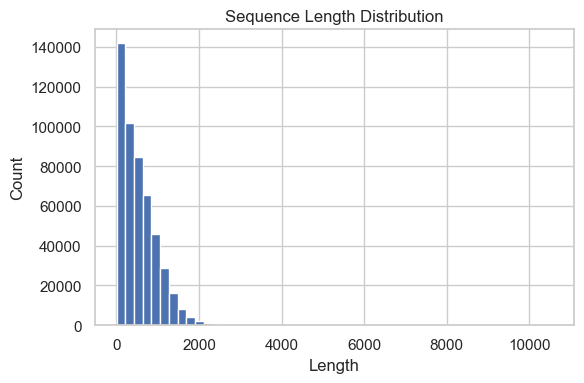

In [56]:
# EDA of 'seq' variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

# Sanity checks: required columns must exist
assert 'seq' in train_df.columns, "train_df must contain a 'seq' column."
assert 'clicked' in train_df.columns, "train_df must contain a 'clicked' column."

# 1) Filter out NA and compute sequence length on the full dataset
df_seq = train_df[train_df['seq'].notna()].copy()

# Sequence length = number of commas + 1 (defensive for empty strings)
len_raw = df_seq['seq'].str.count(',').fillna(-1).astype('int64') + 1
df_seq['seq_length'] = np.clip(len_raw, a_min=0, a_max=None)

# 2) Histogram: sample only for plotting to avoid heavy rendering on very large data
PLOT_SAMPLE_N = min(500_000, len(df_seq))  # adjust if you want fewer/more points in the plot
plot_sample = (
    df_seq['seq_length'].sample(PLOT_SAMPLE_N, random_state=42)
    if len(df_seq) > PLOT_SAMPLE_N else
    df_seq['seq_length']
)

plt.figure(figsize=(6, 4))
plt.hist(plot_sample, bins=50)
plt.title("Sequence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [57]:
## Filter NA and compute sequence length (robust)

# strip spaces just in case, keep empty strings as length 0 (then clip to >=1 if needed)
seq_clean = df_seq['seq'].astype(str).str.strip()

# length = number of commas + 1; if string is empty, treat length as 0 then clip to >=1
len_raw = seq_clean.str.count(',').astype('int64') + 1
df_seq['seq_length'] = np.clip(len_raw, a_min=1, a_max=None)

In [58]:
# Sequence length summary (sample-based; fast & stable)

SAMPLE_N_STATS = min(500_000, len(df_seq))
seq_len_sample = df_seq['seq_length'].sample(SAMPLE_N_STATS, random_state=42)

summary = seq_len_sample.describe(percentiles=[.25, .5, .75, .90, .95, .99])
print("== Sequence length summary (sample) ==")
print(summary.to_string())

== Sequence length summary (sample) ==
count   500000.00
mean       530.78
std        435.94
min          1.00
25%        182.00
50%        439.00
75%        780.00
90%       1125.00
95%       1345.00
99%       1847.00
max      10560.00


In [59]:
# Top frequent items in sequences (sample-based)

SAMPLE_N_ITEMS = min(500_000, len(df_seq))
sample_seqs = df_seq['seq'].sample(SAMPLE_N_ITEMS, random_state=42).tolist()

# Flatten tokens
all_items = pd.Series(item for s in sample_seqs for item in s.split(','))
top_items = all_items.value_counts().head(15)
print(top_items)

74     20354569
101    20263578
479    17347780
57     17237518
408    16406660
269    15358658
77     12938904
317     9188034
318     7529290
132     7003223
207     6786716
532     5709730
516     5519126
51      5251554
35      5145155
Name: count, dtype: int64


In [60]:
# Longest consecutive repeat length and its impact on CTR
SAMPLE_N_RUN = min(300_000, len(df_seq))  # most expensive step → smaller sample
tmp = df_seq.sample(SAMPLE_N_RUN, random_state=42).copy()

def max_run(seq: str) -> int:
    prev, run, best = None, 0, 0
    for tok in seq.split(','):
        if tok == prev:
            run += 1
        else:
            run = 1
            prev = tok
        if run > best:
            best = run
    return best

tmp['max_run'] = tmp['seq'].map(max_run)
tmp['run_ge_10'] = (tmp['max_run'] >= 10)

ctr_by_run = tmp.groupby('run_ge_10').agg(
    ctr=('clicked','mean'), count=('clicked','size'),
    avg_run=('max_run','mean')
)
ctr_by_run

,ctr,count,avg_run
run_ge_10,,,
False,0.02,182992,3.73
True,0.02,117008,23.10


In [61]:
# First token CTR (full) using regex extract (faster than split)
first_tok = df_seq['seq'].str.extract(r'^([^,]+)', expand=False)
ctr_first = pd.DataFrame({'first': first_tok, 'clicked': df_seq['clicked']}) \
    .groupby('first').agg(ctr=('clicked','mean'), count=('clicked','size')) \
    .query('count >= 100').sort_values('ctr', ascending=False)
ctr_first.head(15)

,ctr,count
first,,
534,0.12,508
1,0.10,614
369,0.10,131
200,0.08,100
75,0.07,158
152,0.05,210
103,0.04,158
544,0.04,206
283,0.04,224


In [62]:
# Last token CTR (full)
last_tok = df_seq['seq'].str.extract(r'([^,]+)$', expand=False)
ctr_last = pd.DataFrame({'last': last_tok, 'clicked': df_seq['clicked']}) \
    .groupby('last').agg(ctr=('clicked','mean'), count=('clicked','size')) \
    .query('count >= 100').sort_values('ctr', ascending=False)
ctr_last.head(15)

,ctr,count
last,,
534,0.10,753
200,0.09,119
1,0.07,244
561,0.07,172
442,0.06,152
528,0.06,392
321,0.05,7517
68,0.05,126
24,0.04,202


In [63]:
# CTR by unique-ratio bin (sample-based; full-data would be too slow)

UNIQ_CTR_SAMPLE_N = min(500_000, len(df_seq))
uniq_ctr_sample = df_seq[['seq', 'clicked']].sample(UNIQ_CTR_SAMPLE_N, random_state=42).copy()

def _uniq_ratio(s: str) -> float:
    toks = s.split(',')
    return len(set(toks)) / max(1, len(toks))

uniq_ctr_sample['unique_ratio'] = uniq_ctr_sample['seq'].apply(_uniq_ratio)
uniq_ctr_sample['unique_bin'] = pd.cut(
    uniq_ctr_sample['unique_ratio'],
    bins=[0, 0.10, 0.15, 0.20, 0.30, 1],
    labels=["<10%", "10-15%", "15-20%", "20-30%", ">30%"],
    include_lowest=True
)

ctr_by_unique = (
    uniq_ctr_sample.dropna(subset=['unique_bin'])
                   .groupby('unique_bin', observed=True)
                   .agg(ctr=('clicked','mean'), count=('clicked','size'))
)
print(ctr_by_unique)

            ctr   count
unique_bin             
<10%       0.02  177405
10-15%     0.02  123301
15-20%     0.02   69214
20-30%     0.02   66424
>30%       0.03   63656


In [64]:
# Bigram → CTR 

import pandas as pd
from collections import defaultdict

SAMPLE_N   = 500_000 
MIN_COUNT  = 5_000                      # filter out noisy/rare bigrams
TOPN       = 20
RANDOM_SEED= 42

tmp = df_seq[['seq','clicked']].sample(SAMPLE_N, random_state=RANDOM_SEED)

cnt = defaultdict(int)
pos = defaultdict(int)

for s, y in zip(tmp['seq'].values, tmp['clicked'].values):
    toks = s.split(',')
    if len(toks) < 2:
        continue
    y_int = int(y)
    for a, b in zip(toks[:-1], toks[1:]):
        g = f"{a}->{b}"
        cnt[g] += 1
        pos[g] += y_int

rows = [(g, c, pos[g]) for g, c in cnt.items() if c >= MIN_COUNT]
df_bigram = pd.DataFrame(rows, columns=['bigram','count','pos']).sort_values('count', ascending=False)

if df_bigram.empty:
    print("No bigrams met MIN_COUNT. Increase SAMPLE_N or lower MIN_COUNT cautiously.")
else:
    df_bigram['ctr'] = df_bigram['pos'] / df_bigram['count']
    global_ctr = tmp['clicked'].mean()
    df_bigram['ctr_lift'] = df_bigram['ctr'] / max(global_ctr, 1e-12)

    print(f"Sample: {SAMPLE_N:,} | Global CTR: {global_ctr:.4f} | "
          f"Bigrams kept (≥{MIN_COUNT}): {len(df_bigram):,}")

    top_ctr   = df_bigram.sort_values(['ctr','count'], ascending=[False, False]).head(TOPN)
    bot_ctr   = df_bigram.sort_values(['ctr','count'], ascending=[True,  False]).head(TOPN)
    top_freq  = df_bigram.sort_values('count', ascending=False).head(TOPN)

    print("\nTop bigrams by CTR (min_count filter applied):")
    display(top_ctr.reset_index(drop=True))

    print("\nLowest-CTR bigrams (still frequent):")
    display(bot_ctr.reset_index(drop=True))

    print("\nMost frequent bigrams:")
    display(top_freq.reset_index(drop=True))

Sample: 500,000 | Global CTR: 0.0190 | Bigrams kept (≥5000): 1,596

Top bigrams by CTR (min_count filter applied):


,bigram,count,pos,ctr,ctr_lift
0,77->370,6793,312,0.05,2.42
1,114->114,5699,246,0.04,2.28
2,74->370,5843,229,0.04,2.07
3,207->370,12790,501,0.04,2.07
4,416->106,8206,321,0.04,2.06
5,106->516,18073,670,0.04,1.96
6,106->416,8540,316,0.04,1.95
7,114->338,6358,233,0.04,1.93
8,114->223,6234,222,0.04,1.88
9,370->479,26658,928,0.03,1.84



Lowest-CTR bigrams (still frequent):


,bigram,count,pos,ctr,ctr_lift
0,248->248,9787,77,0.01,0.42
1,173->223,5453,60,0.01,0.58
2,242->527,8808,99,0.01,0.59
3,497->434,10948,124,0.01,0.60
4,227->138,11433,131,0.01,0.60
5,132->227,23568,271,0.01,0.61
6,36->227,5208,60,0.01,0.61
7,269->36,5976,69,0.01,0.61
8,373->120,29885,347,0.01,0.61
9,207->140,9467,113,0.01,0.63



Most frequent bigrams:


,bigram,count,pos,ctr,ctr_lift
0,479->57,10413340,179948,0.02,0.91
1,408->408,9154765,138401,0.02,0.80
2,74->77,7871700,130915,0.02,0.88
3,101->101,7685996,127238,0.02,0.87
4,77->317,4140873,68183,0.02,0.87
5,74->318,3708144,69218,0.02,0.99
6,101->132,3268273,49714,0.02,0.80
7,132->101,3261335,50162,0.02,0.81
8,74->317,3251231,55290,0.02,0.90
9,479->35,3219136,58659,0.02,0.96


In [65]:
# CTR by sequence length bin (full-dataset; keep as-is for accuracy)

q = df_seq['seq_length'].quantile([.25, .5, .75, .95]).astype(int).to_dict()
bins = [0, q[.25], q[.5], q[.75], q[.95], np.inf]
labels = ["Very Short(<Q1)", "Short(Q1-Q2)", "Medium(Q2-Q3)", "Long(Q3-95th)", "Very Long(>95th)"]

tmp = df_seq[['seq_length', 'clicked']].copy()
tmp['seq_len_bin'] = pd.cut(tmp['seq_length'], bins=bins, labels=labels, include_lowest=True)

ctr_by_length = (
    tmp.groupby('seq_len_bin', observed=True)
       .agg(ctr=('clicked','mean'), count=('clicked','size'), avg_length=('seq_length','mean'))
       .sort_values('ctr', ascending=False)
)
print(ctr_by_length)

                  ctr    count  avg_length
seq_len_bin                               
Very Short(<Q1)  0.03  1825158       82.34
Short(Q1-Q2)     0.02  1815580      305.91
Very Long(>95th) 0.02   362964     1665.69
Medium(Q2-Q3)    0.02  1820720      598.45
Long(Q3-95th)    0.02  1454419     1005.77


In [66]:
import re
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score, log_loss
from xgboost import XGBClassifier

# ---------- config ----------
SEEDS = [42, 202, 7]          # repeat with multiple seeds
TRAIN_SAMPLE_N = 300_000      # small sample for quick test
VALID_SAMPLE_N = 300_000      # eval on a subset to speed up
TOPK_FIRST_LAST = 30          # vocab size for first/last tokens
MIN_COUNT_FIRST_LAST = 1_000  # min freq for vocab inclusion

# categorical columns 
CAT_COLS_FIXED = [
    "gender", "age_group", "inventory_id", "day_of_week", "hour",
    "l_feat_1", "l_feat_2", "l_feat_3","l_feat_4", "l_feat_8", "l_feat_13",
    "l_feat_16", "l_feat_18", "l_feat_19", "l_feat_20", "l_feat_21",
    "l_feat_22", "l_feat_23", "l_feat_24", "l_feat_26", "l_feat_27"
]

# ---------- metrics ----------
def weighted_logloss_5050(y_true: np.ndarray, p: np.ndarray) -> float:
    """50:50 weighted logloss for imbalanced data."""
    eps = 1e-15
    p = np.clip(p, eps, 1 - eps)
    n_pos = int(y_true.sum())
    n_neg = len(y_true) - n_pos
    if n_pos == 0 or n_neg == 0:
        return float(log_loss(y_true, p))
    w_pos = 0.5 / n_pos
    w_neg = 0.5 / n_neg
    w = np.where(y_true == 1, w_pos, w_neg)
    loss = -(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    return float(np.sum(w * loss))

def portfolio_score(ap: float, wll: float) -> float:
    return 0.5 * ap + 0.5 * (1.0 / (1.0 + wll))

# ---------- seq vocab & transforms (fit on TRAIN ONLY) ----------
def fit_seq_vocab(seq_series: pd.Series, top_k: int = 30, min_count: int = 1000):
    """Build first/last token vocab from train only."""
    s = seq_series.dropna().astype(str)
    first = s.str.extract(r'^([^,]+)', expand=False)
    last  = s.str.extract(r'([^,]+)$', expand=False)
    vf = first.value_counts()
    vl = last.value_counts()
    first_tokens = vf[vf >= min_count].head(top_k).index.tolist()
    last_tokens  = vl[vl >= min_count].head(top_k).index.tolist()
    return {"first": first_tokens, "last": last_tokens}

# transform_seq_features without duplicate computations
def transform_seq_features(df: pd.DataFrame, vocab: dict, q1: int, p95: int) -> pd.DataFrame:
    """Create compact seq-derived features."""
    out = pd.DataFrame(index=df.index)
    s = df['seq'].fillna("").astype(str).str.strip()

    # length + simple bins
    seq_len = s.str.count(',').astype('int64') + 1
    out['seq_len'] = seq_len.astype('int32')
    out['seq_log_len'] = np.log1p(seq_len).astype('float32')
    out['seq_is_short'] = (seq_len < q1).astype('uint8')
    out['seq_is_very_long'] = (seq_len > p95).astype('uint8')

    # repeat flags
    repeat_pat = re.compile(r'(?:^|,)([^,]+),(?:\1)(?:,|$)')
    run10_pat  = re.compile(r'(?:^|,)([^,]+)(?:,\1){9,}(?:,|$)')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        out['seq_has_repeat'] = s.str.contains(repeat_pat, na=False).astype('uint8')
        out['seq_run_ge_10']  = s.str.contains(run10_pat,  na=False).astype('uint8')

    # first/last restricted one-hot (+OTHER)
    first = s.str.extract(r'^([^,]+)', expand=False).fillna('')
    last  = s.str.extract(r'([^,]+)$',  expand=False).fillna('')

    first_set = set(vocab.get('first', []))
    out['seq_first_OTHER'] = (~first.isin(first_set)).astype('uint8')
    for tok in first_set:
        out[f'seq_first_{tok}'] = (first == tok).astype('uint8')

    last_set = set(vocab.get('last', []))
    out['seq_last_OTHER'] = (~last.isin(last_set)).astype('uint8')
    for tok in last_set:
        out[f'seq_last_{tok}'] = (last == tok).astype('uint8')

    return out


# ---------- data prep ----------
def stratified_sample(df: pd.DataFrame, n: int, y_col: str, seed: int) -> pd.DataFrame:
    """Stratified sample by target."""
    n = min(n, len(df))
    if n <= 0:
        return df.copy()
    frac_pos = df[y_col].mean()
    n_pos = int(round(n * frac_pos))
    n_neg = n - n_pos
    pos = df[df[y_col] == 1].sample(min(n_pos, len(df[df[y_col]==1])), random_state=seed)
    neg = df[df[y_col] == 0].sample(min(n_neg, len(df[df[y_col]==0])), random_state=seed)
    return pd.concat([pos, neg]).sample(frac=1.0, random_state=seed).reset_index(drop=True)

def prepare_for_xgb(Xtr: pd.DataFrame, Xva: pd.DataFrame, cat_cols_all):
    """Cast categories, handle missing, drop object columns, cast nullable ints."""
    import pandas as pd
    Xtr = Xtr.copy()
    Xva = Xva.copy()

    # remove raw seq if present
    for bad in ["seq"]:
        if bad in Xtr.columns: Xtr.drop(columns=[bad], inplace=True)
        if bad in Xva.columns: Xva.drop(columns=[bad], inplace=True)

    # cast declared categorical cols (present only)
    cat_cols = [c for c in cat_cols_all if c in Xtr.columns or c in Xva.columns]
    for c in cat_cols:
        if c in Xtr.columns and not isinstance(Xtr[c].dtype, pd.CategoricalDtype):
            Xtr[c] = Xtr[c].astype("category")
        if c in Xva.columns and not isinstance(Xva[c].dtype, pd.CategoricalDtype):
            Xva[c] = Xva[c].astype("category")

    # add missing category and fillna
    for c in cat_cols:
        if c in Xtr.columns and isinstance(Xtr[c].dtype, pd.CategoricalDtype):
            if "__MISSING__" not in Xtr[c].cat.categories:
                Xtr[c] = Xtr[c].cat.add_categories(["__MISSING__"])
            Xtr[c] = Xtr[c].fillna("__MISSING__")
        if c in Xva.columns and isinstance(Xva[c].dtype, pd.CategoricalDtype):
            if "__MISSING__" not in Xva[c].cat.categories:
                Xva[c] = Xva[c].cat.add_categories(["__MISSING__"])
            Xva[c] = Xva[c].fillna("__MISSING__")

    # drop any remaining object cols
    obj_cols = list(set(Xtr.select_dtypes(include=["object"]).columns) |
                    set(Xva.select_dtypes(include=["object"]).columns))
    if obj_cols:
        Xtr.drop(columns=[c for c in obj_cols if c in Xtr.columns], inplace=True, errors="ignore")
        Xva.drop(columns=[c for c in obj_cols if c in Xva.columns], inplace=True, errors="ignore")

    # cast pandas nullable ints to float64 (XGBoost friendly)
    for df in (Xtr, Xva):
        for c in df.select_dtypes(include="Int64").columns:
            df[c] = df[c].astype("float64")

    return Xtr, Xva

In [67]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

def run_once(seed: int):
    tr_s = stratified_sample(train_df, TRAIN_SAMPLE_N, "clicked", seed)
    va_s = stratified_sample(valid_df, VALID_SAMPLE_N, "clicked", seed)

    y_tr = tr_s['clicked'].astype('int8').to_numpy()
    y_va = va_s['clicked'].astype('int8').to_numpy()

    s = tr_s['seq'].fillna("").astype(str)
    seq_len_tr = s.str.count(',').astype('int64') + 1
    q1 = int(np.quantile(seq_len_tr, 0.25))
    p95 = int(np.quantile(seq_len_tr, 0.95))

    vocab = fit_seq_vocab(tr_s['seq'], top_k=TOPK_FIRST_LAST, min_count=MIN_COUNT_FIRST_LAST)
    Xtr_seq = transform_seq_features(tr_s, vocab, q1, p95)
    Xva_seq = transform_seq_features(va_s, vocab, q1, p95)

    drop_cols = ['clicked', 'seq']
    Xtr_base = tr_s.drop(columns=[c for c in drop_cols if c in tr_s.columns])
    Xva_base = va_s.drop(columns=[c for c in drop_cols if c in va_s.columns])

    Xtr_plus = pd.concat([Xtr_base.reset_index(drop=True), Xtr_seq.reset_index(drop=True)], axis=1)
    Xva_plus = pd.concat([Xva_base.reset_index(drop=True), Xva_seq.reset_index(drop=True)], axis=1)

    Xtr_base_c, Xva_base_c = prepare_for_xgb(Xtr_base, Xva_base, CAT_COLS_FIXED)
    Xtr_plus_c, Xva_plus_c = prepare_for_xgb(Xtr_plus, Xva_plus, CAT_COLS_FIXED)

    n_pos = int(y_tr.sum())
    n_neg = len(y_tr) - n_pos
    spw = n_neg / max(n_pos, 1)

    LGB_PARAMS = dict(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=255,
        max_depth=-1,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary",
        n_jobs=-1,
        random_state=seed,
        scale_pos_weight=spw,
        reg_alpha=0.0,
        reg_lambda=0.0,
        verbosity=-1,
    )

    def fit_eval(Xtr, Xva, label):
        model = LGBMClassifier(**LGB_PARAMS)
        model.fit(
            Xtr, y_tr,
            eval_set=[(Xva, y_va)],
            eval_metric="binary_logloss",
            callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(0)],
        )
        best_iter = getattr(model, "best_iteration_", None)
        if best_iter is None:
            p = model.predict_proba(Xva)[:, 1]
        else:
            p = model.predict_proba(Xva, num_iteration=best_iter)[:, 1]
        ap  = average_precision_score(y_va, p)
        auc = roc_auc_score(y_va, p)
        wll = weighted_logloss_5050(y_va, p)
        port = portfolio_score(ap, wll)
        return dict(label=label, seed=seed, AP=ap, ROC_AUC=auc, WLL_50_50=wll, Portfolio=port)

    m_base = fit_eval(Xtr_base_c, Xva_base_c, "Baseline")
    m_plus = fit_eval(Xtr_plus_c, Xva_plus_c, "Baseline+Seq")
    return m_base, m_plus


In [68]:

# ---------- run multiple seeds and summarize ----------
all_rows = []
for sd in SEEDS:
    r_base, r_plus = run_once(sd)
    all_rows.extend([r_base, r_plus])

res = pd.DataFrame(all_rows).set_index(["seed","label"]).sort_index()
print("Per-seed results:")
display(res)

summary = (res.reset_index()
             .pivot_table(index="label", values=["AP","ROC_AUC","WLL_50_50","Portfolio"], aggfunc=['mean','std']))
print("Summary (mean ± std across seeds):")
display(summary)

# quick delta view
delta = (res.reset_index()
           .pivot_table(index="seed", columns="label", values=["AP","ROC_AUC","WLL_50_50","Portfolio"]))
delta.columns = ['_'.join(col).strip() for col in delta.columns.values]
delta["dAP"] = delta["AP_Baseline+Seq"] - delta["AP_Baseline"]
delta["dAUC"] = delta["ROC_AUC_Baseline+Seq"] - delta["ROC_AUC_Baseline"]
delta["dWLL"] = delta["WLL_50_50_Baseline+Seq"] - delta["WLL_50_50_Baseline"]  # <0 is good
delta["dPORT"] = delta["Portfolio_Baseline+Seq"] - delta["Portfolio_Baseline"]
print("Per-seed deltas (Plus - Base):")
display(delta)

print("Decision hint:")
print("- Favor +Seq if mean dAP>0, mean dWLL<0, mean dPORT>0 and deltas are consistent across seeds.")

Per-seed results:


AP  ROC_AUC  WLL_50_50  Portfolio
seed label                                           
7    Baseline     0.04     0.65       1.38       0.23
     Baseline+Seq 0.04     0.65       1.38       0.23
42   Baseline     0.04     0.67       1.37       0.23
     Baseline+Seq 0.04     0.66       1.37       0.23
202  Baseline     0.05     0.67       1.36       0.23
     Baseline+Seq 0.04     0.64       1.38       0.23

Summary (mean ± std across seeds):


mean                              std                            
               AP Portfolio ROC_AUC WLL_50_50   AP Portfolio ROC_AUC WLL_50_50
label                                                                         
Baseline     0.04      0.23    0.66      1.37 0.00      0.00    0.01      0.01
Baseline+Seq 0.04      0.23    0.65      1.38 0.00      0.00    0.01      0.01

Per-seed deltas (Plus - Base):


,AP_Baseline,AP_Baseline+Seq,Portfolio_Baseline,Portfolio_Baseline+Seq,ROC_AUC_Baseline,ROC_AUC_Baseline+Seq,WLL_50_50_Baseline,WLL_50_50_Baseline+Seq,dAP,dAUC,dWLL,dPORT
seed,,,,,,,,,,,,
7,0.04,0.04,0.23,0.23,0.65,0.65,1.38,1.38,0.00,-0.00,0.00,0.00
42,0.04,0.04,0.23,0.23,0.67,0.66,1.37,1.37,0.00,-0.00,0.00,-0.00
202,0.05,0.04,0.23,0.23,0.67,0.64,1.36,1.38,-0.00,-0.02,0.02,-0.00


Decision hint:
- Favor +Seq if mean dAP>0, mean dWLL<0, mean dPORT>0 and deltas are consistent across seeds.


### Sequence Feature Decision

Sequence-derived features (e.g., length, repetition, first/last tokens, diversity, bigrams) were engineered from the `seq` field.

Modeling experiments across 3 seeds showed:
- No consistent gain across AP, ROC-AUC, or weighted logloss (ΔAP ≤ ±0.0004)

➡️ **Excluded from final model due to negligible lift and added complexity**


In [69]:
# Schema synchronization before saving
cols_keep = sorted(set(train_df.columns) & set(valid_df.columns) & set(holdout_df.columns))
train_df = train_df[cols_keep].copy()
valid_df = valid_df[cols_keep].copy()
holdout_df = holdout_df[cols_keep].copy()

train_df.to_parquet("../data/train_clean.parquet")
valid_df.to_parquet("../data/valid_clean.parquet")
holdout_df.to_parquet("../data/holdout_clean.parquet")
